In [2]:
import importlib
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics

import extq
import ivac
from extq.stop import forward_stop

/Users/Spencer/anaconda3/envs/civsd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [5]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet (optional)
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

/var/folders/63/x_tg6ggj4ygcrmv3t6tl94yc0000gp/T/ipykernel_26475/2661385583.py:20: UserWarning: Overwriting the cmap 'diverging' that was already in the registry.
  mpl.colormaps.register(cm_div, force=True)


In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Load data

In [7]:
DATA_DIR = "../../public/" # change this directory name as appropriate for your system
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# weights
weights = np.load(
    f"{DATA_DIR}/weights_3_feat5ivac.npy", allow_pickle=True
)[
    8
]  # 0.1 ns lag time
j_du_ds = np.load(f"{DATA_DIR}/j_du_ds_3.npy", allow_pickle=True)[6]  # 10 ns lag time

In [8]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [9]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

In [8]:
# Rong's reference REUS PMF data
pmf_ref = np.loadtxt(f"{DATA_DIR}/wham2d_remd_neutral_30ns.dat")
# reshape into 2D data
pmf_ref = np.array(np.split(pmf_ref, 95, axis=0))
nx, ny, _ = pmf_ref.shape

In [9]:
xlim = pmf_ref[:, 0, 0]
ylim = pmf_ref[0, :, 1]

# compute pmf from DGA by binning weights
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights, xlim, ylim)
xcent = (xlim[1:] + xlim[:-1]) / 2
ycent = (ylim[1:] + ylim[:-1]) / 2
offset = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol

/scratch/local/jobs/278587/ipykernel_860349/3040673555.py:11: RuntimeWarning: divide by zero encountered in log
  diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol


In [10]:
# compute E[\theta(x) S_tq_+(x)]
dist_trajs_delay = [t[:-lag, 0] for t in cv_trajs]
rot_trajs_delay = [t[:-lag, 1] for t in cv_trajs]
w_delay = [w[:-lag] for w in weights]
qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

In [11]:
models = np.loadtxt("/project/dinner/scguo/ci-vsd/models/MD-clustering-center/all.txt")

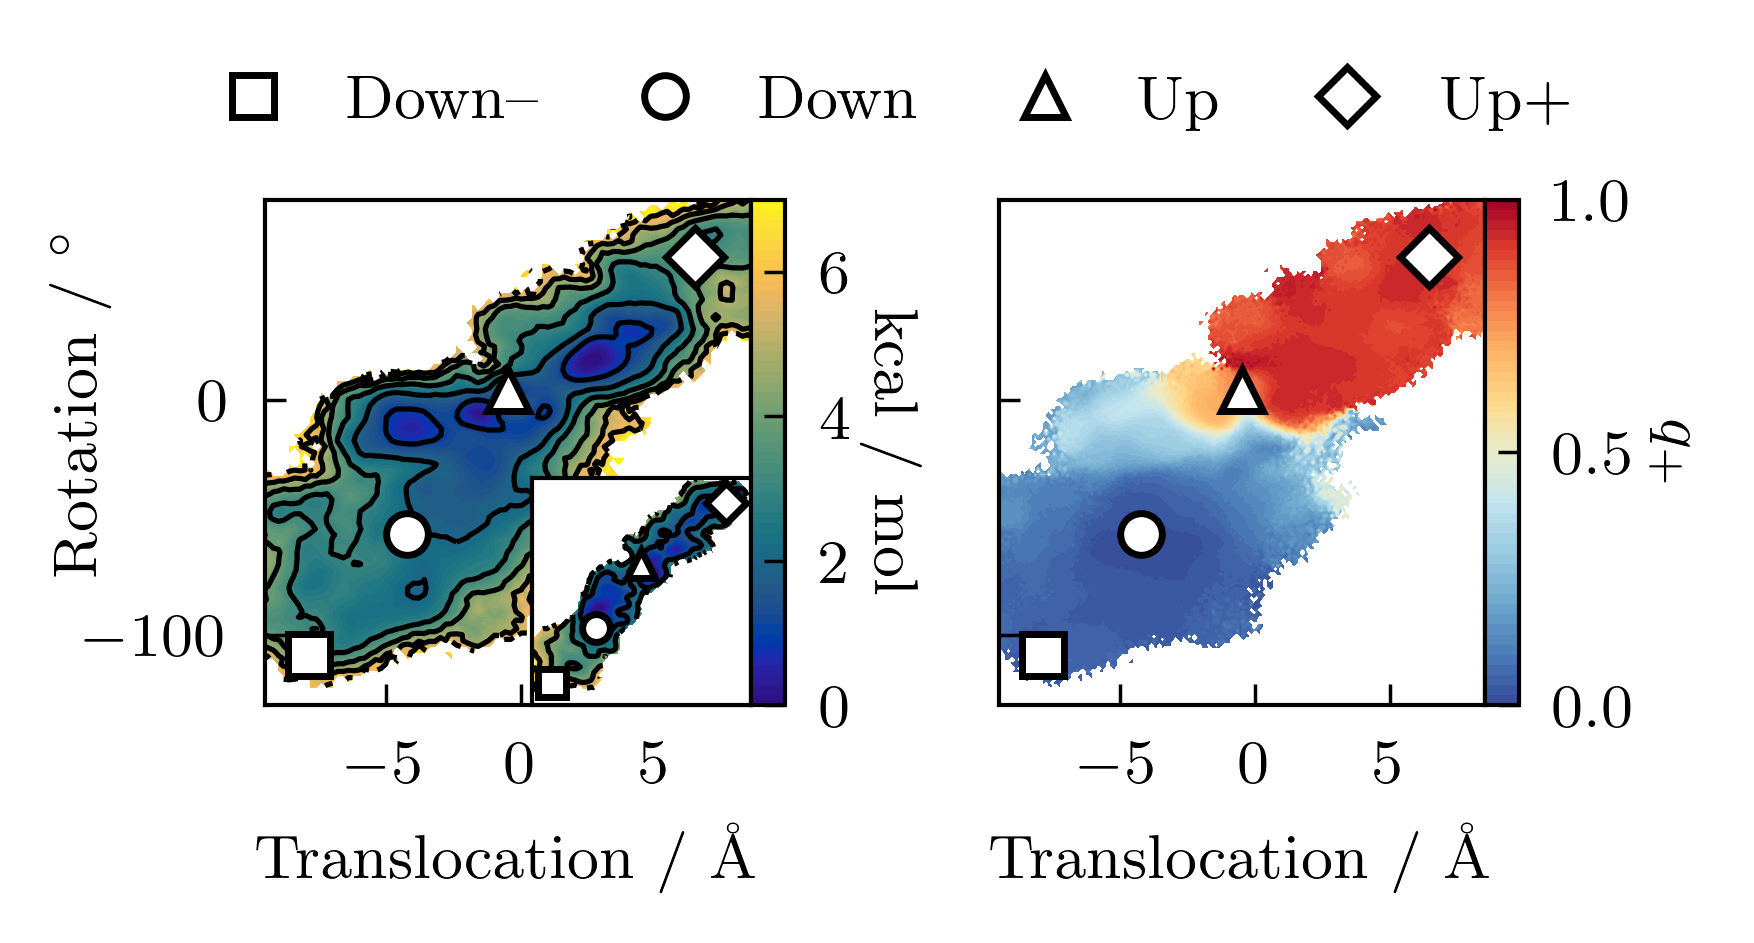

In [38]:
plt.rcParams['font.size'] = 9
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(3.6, 1.7), dpi=500, sharex=True, sharey=True)
vmin, vmax = 0, 7
clines = np.linspace(
    vmin, vmax, (vmax - vmin) + 1
)  # contour lines spaced every 1 kcal/mol

xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85

plotting.plot_models(ax0, models, ms=6, zorder=5)
f.legend(
    bbox_to_anchor=(0.5, 1.01),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=1,
    handletextpad=0.5,
)
# plot PMF
xcent = (xlim[1:] + xlim[:-1]) / 2
ycent = (ylim[1:] + ylim[:-1]) / 2
levels = np.linspace(vmin, vmax, 51)
pc0 = ax0.contourf(
    xcent, ycent, diff.T, cmap="macaw", levels=levels, vmin=vmin, vmax=vmax
)
ax0.contour(xcent, ycent, diff.T, colors="black")
cb = pplt.colorbar(pc0, ax=ax0, extend="max")
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
cb.set_ticks(np.linspace(0, 6, 4))

# plot Rong's PMF as inset
ax_ins = ax0.inset_axes([0.55, 0.0, 0.45, 0.45])
pc1 = ax_ins.contourf(
    xlim,
    ylim,
    pmf_ref[:, :, 2].T * 0.593,
    cmap="macaw",
    levels=levels,
    vmin=vmin,
    vmax=vmax,
)
ax_ins.contour(xlim, ylim, pmf_ref[:, :, 2].T * 0.593, colors="black")
plotting.format_cvs(ax_ins, centroids=True, ms=4)
ax_ins.set_xticks([])
ax_ins.set_yticks([])
ax_ins.set_xlabel(None)
ax_ins.set_ylabel(None)
ax_ins.set_xlim([xmin, xmax])
ax_ins.set_ylim([ymin, ymax])

# bin commitors
xe = np.linspace(-10, 10, 201)
ye = np.linspace(-150, 100, 201)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
q_dens = extq.projection.average2d(
    dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye
)
# plot committors
plotting.plot_models(ax1, models, ms=6, zorder=5)
levels = np.linspace(0, 1.0, 51)
pc1 = ax1.contourf(
    xcent, ycent, q_dens.T, cmap="diverging", levels=levels, vmin=0, vmax=1
)
cb1 = pplt.colorbar(pc1, ax=ax1)
cb1.set_label("$q_+$", rotation=-90, labelpad=10)
cb1.set_ticks(np.linspace(0, 1, 3))

# format labels
for ax in (ax0, ax1):
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel("Translocation / Å")
    ax.set_ylabel("Rotation / $^\circ$", labelpad=-4.0, y=0.6)
    ax.label_outer()
f.tight_layout()

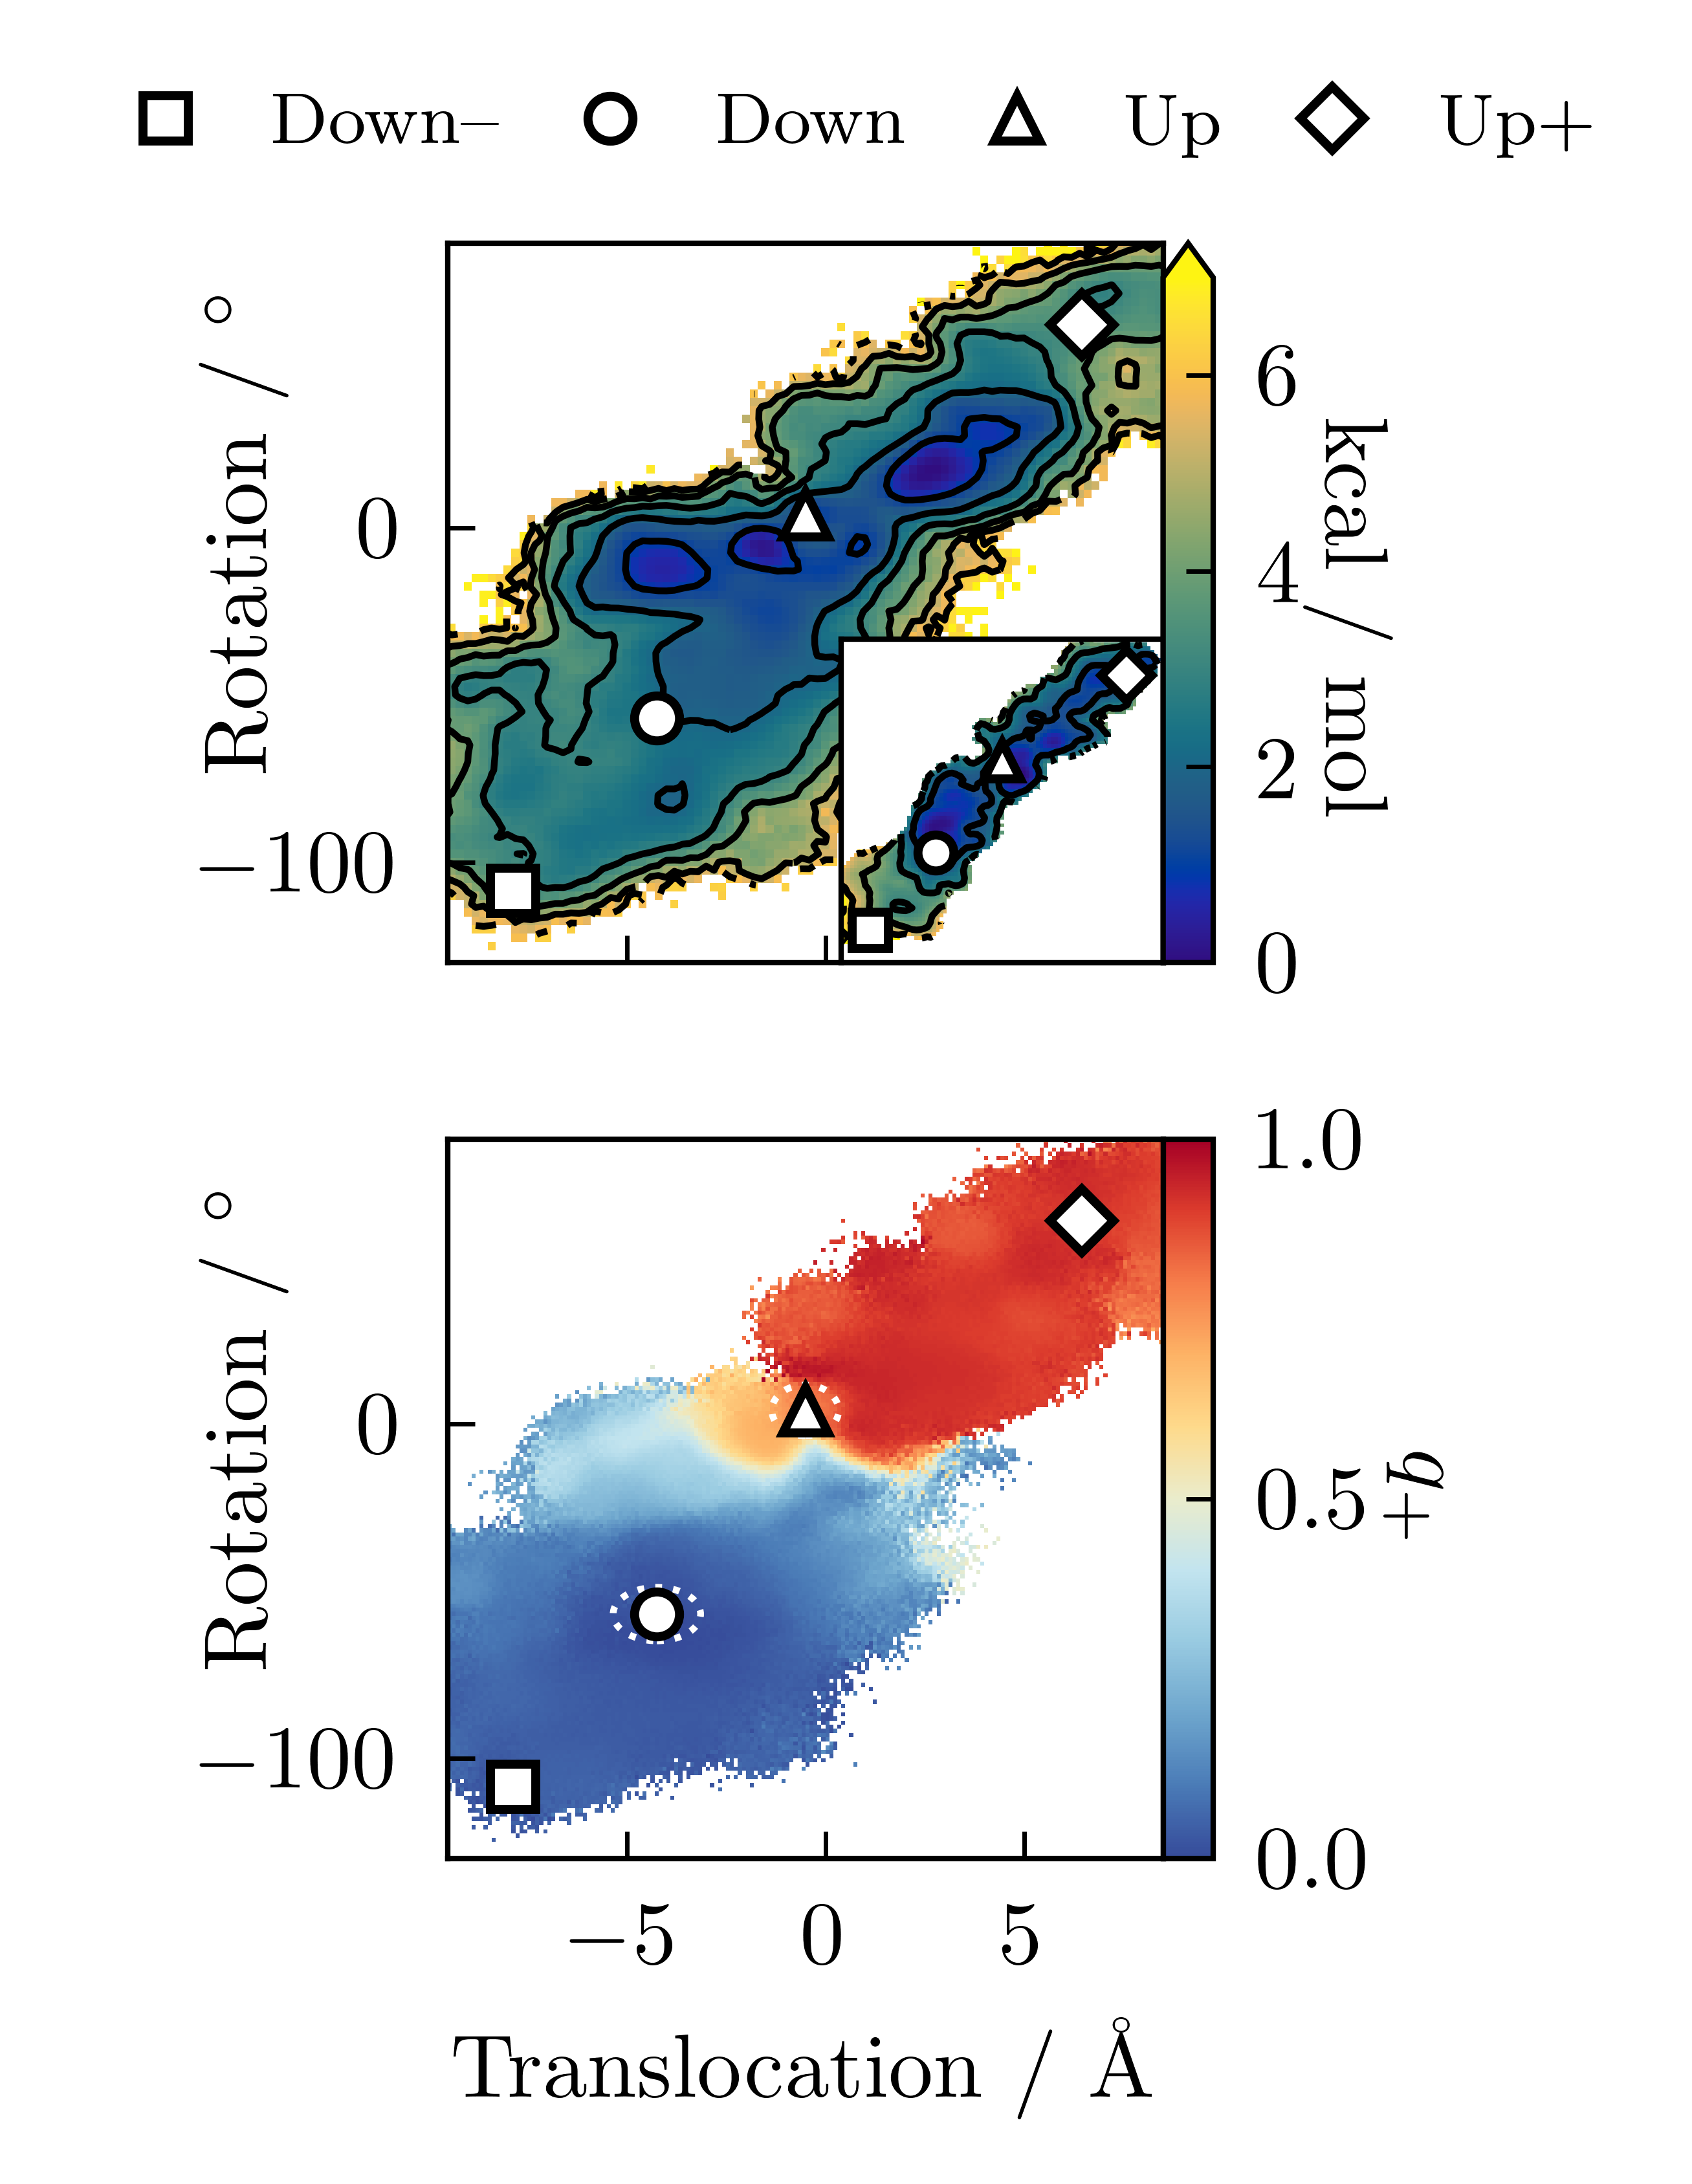

In [14]:
f, (ax0, ax1) = plt.subplots(2, 1, figsize=(2.3, 3.2), dpi=500, sharex=True, sharey=True)
vmin, vmax = 0, 7
clines = np.linspace(
    vmin, vmax, (vmax - vmin) + 1
)  # contour lines spaced every 1 kcal/mol

xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85

plotting.plot_models(ax0, models, ms=5, zorder=5)
f.legend(
    bbox_to_anchor=(0.5, 1.01),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=0.5,
    handletextpad=0.5,
    fontsize=8
)
# plot PMF
xcent = (xlim[1:] + xlim[:-1]) / 2
ycent = (ylim[1:] + ylim[:-1]) / 2
levels = np.linspace(vmin, vmax, 51)
pc0 = ax0.pcolormesh(
    xcent, ycent, diff.T, cmap="macaw", vmin=vmin, vmax=vmax, rasterized=True
)
ax0.contour(xcent, ycent, diff.T, colors="black")
cb = pplt.colorbar(pc0, ax=ax0, extend="max")
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
cb.set_ticks(np.linspace(0, 6, 4))

# plot Rong's PMF as inset
ax_ins = ax0.inset_axes([0.55, 0.0, 0.45, 0.45])
pc1 = ax_ins.pcolormesh(
    xlim,
    ylim,
    pmf_ref[:, :, 2].T * 0.593,
    cmap="macaw",
    # levels=levels,
    vmin=vmin,
    vmax=vmax,
    rasterized=True
)
ax_ins.contour(xlim, ylim, pmf_ref[:, :, 2].T * 0.593, colors="black")
plotting.format_cvs(ax_ins, centroids=True, ms=4)
ax_ins.set_xticks([])
ax_ins.set_yticks([])
ax_ins.set_xlabel(None)
ax_ins.set_ylabel(None)
ax_ins.set_xlim([xmin, xmax])
ax_ins.set_ylim([ymin, ymax])

# bin commitors
xe = np.linspace(-10, 10, 201)
ye = np.linspace(-150, 100, 201)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
q_dens = extq.projection.average2d(
    dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye
)
# plot committors
plotting.plot_models(ax1, models, ms=5, zorder=5)
levels = np.linspace(0, 1.0, 51)
pc1 = ax1.pcolormesh(
    xcent, ycent, q_dens.T, cmap="diverging", vmin=0, vmax=1, zorder=0, rasterized=True
)
cb1 = pplt.colorbar(pc1, ax=ax1)
cb1.set_label("$q_+$", rotation=-90, labelpad=10)
cb1.set_ticks(np.linspace(0, 1, 3))
ellipseA = mpl.patches.Ellipse(xy=(-4.24, -56.95), width=2.2, height=16)
ellipseB = mpl.patches.Ellipse(xy=(-0.506, 3.94), width=0.84*2, height=7.6*2)
for e in (ellipseA, ellipseB):
    e.set_fill(False)
    e.set_linestyle(':')
    e.set_linewidth(0.75)
    e.set_edgecolor("white")
ax1.add_artist(ellipseA)
ax1.add_artist(ellipseB)

# format labels
for ax in (ax0, ax1):
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel("Translocation / Å")
    ax.set_ylabel("Rotation / $^\circ$", labelpad=-10., y=0.6)
    ax.label_outer()
f.tight_layout()
plt.savefig("../../fig/paper/fig1_ds_pmf_q.pdf", bbox_inches='tight')

/scratch/local/jobs/4195197/ipykernel_482878/2810177328.py:25: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f66f6038430> has a label of '_blank' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 0.95), loc='center', ncol=4, labels=["_blank", 'Down–', 'Down', 'Up', 'Up+'], columnspacing=1, handletextpad=0.5)


(-130.0, 85.0)

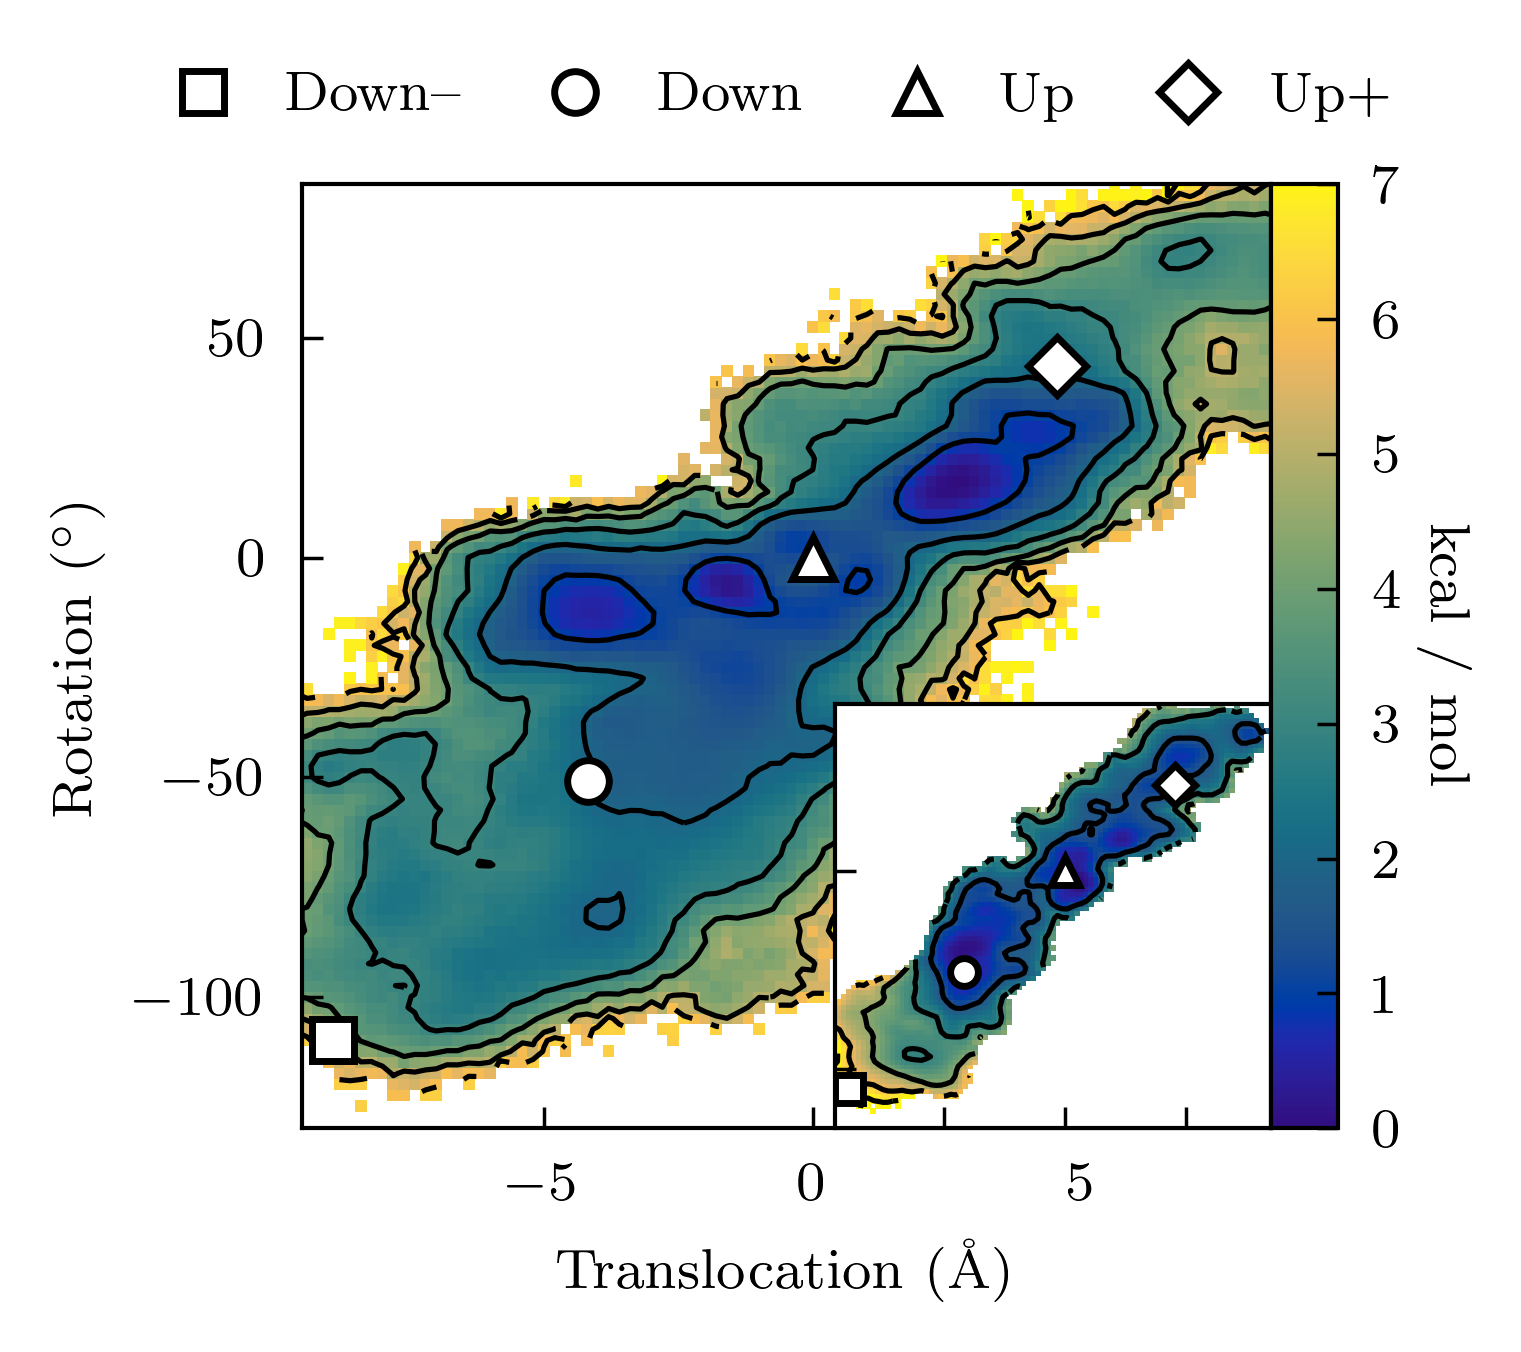

In [13]:
f, ax = plt.subplots(figsize=(2.5, 2.5), dpi=500, sharex=True, sharey=True)
vmin, vmax = 0, 7
clines = np.linspace(
    vmin, vmax, (vmax - vmin) + 1
)  # contour lines spaced every 1 kcal/mol

xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
# plot PMF
pc0 = ax.pcolor(
    xcent, ycent, diff.T, cmap="macaw", shading="auto", vmin=vmin, vmax=vmax
)
ax.contour(xcent, ycent, diff.T, colors="black")

# plot Rong's PMF as inset
ax_ins = ax.inset_axes([0.55, 0.0, 0.45, 0.45])
pc_ins = ax_ins.pcolor(
    xlim,
    ylim,
    pmf_ref[:, :, 2].T * 0.593,
    cmap="macaw",
    shading="auto",
    vmin=vmin,
    vmax=vmax,
)
ax_ins.contour(xlim, ylim, pmf_ref[:, :, 2].T * 0.593, colors="black")

plotting.format_cvs(ax, centroids=False, ms=6)

plotting.format_cvs(ax_ins, centroids=False, ms=4)
ax_ins.set_xticklabels([])
ax_ins.set_yticklabels([])
ax_ins.set_xlabel(None)
ax_ins.set_ylabel(None)
ax_ins.set_xlim([xmin, xmax])
ax_ins.set_ylim([ymin, ymax])
f.legend(
    bbox_to_anchor=(0.5, 0.95),
    loc="center",
    ncol=4,
    labels=["_blank", "Down–", "Down", "Up", "Up+"],
    columnspacing=1,
    handletextpad=0.5,
)

cb = pplt.colorbar(pc0, ax=ax)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

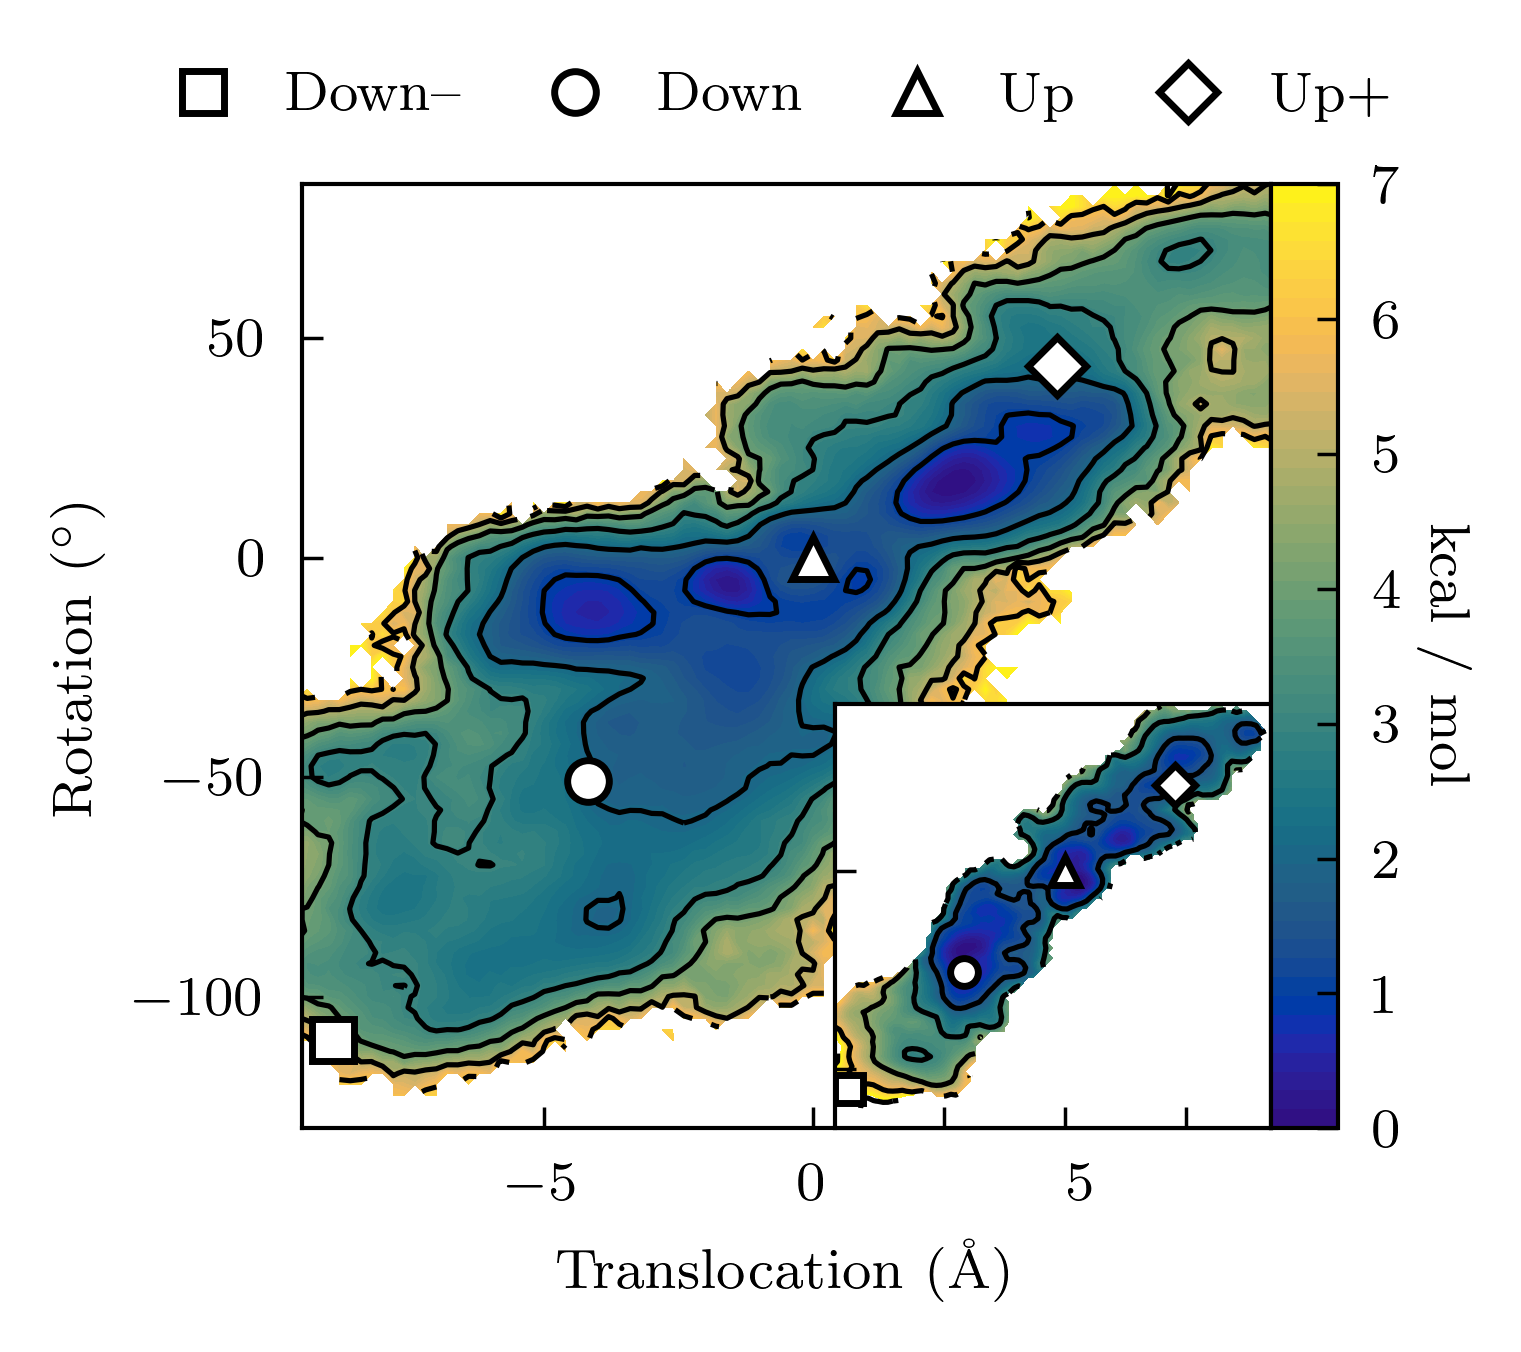

In [14]:
f, ax = plt.subplots(figsize=(2.5, 2.5), dpi=500, sharex=True, sharey=True)
vmin, vmax = 0, 7
clines = np.linspace(
    vmin, vmax, (vmax - vmin) + 1
)  # contour lines spaced every 1 kcal/mol

xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85

plotting.format_cvs(ax, centroids=False, ms=6, zorder=5)
f.legend(
    bbox_to_anchor=(0.5, 0.95),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=1,
    handletextpad=0.5,
)
# plot PMF
xcent = (xlim[1:] + xlim[:-1]) / 2
ycent = (ylim[1:] + ylim[:-1]) / 2
levels = np.linspace(vmin, vmax, 51)
pc0 = ax.contourf(
    xcent, ycent, diff.T, cmap="macaw", levels=levels, vmin=vmin, vmax=vmax
)
ax.contour(xcent, ycent, diff.T, colors="black")

# plot Rong's PMF as inset
ax_ins = ax.inset_axes([0.55, 0.0, 0.45, 0.45])
pc1 = ax_ins.contourf(
    xlim,
    ylim,
    pmf_ref[:, :, 2].T * 0.593,
    cmap="macaw",
    levels=levels,
    vmin=vmin,
    vmax=vmax,
)
ax_ins.contour(xlim, ylim, pmf_ref[:, :, 2].T * 0.593, colors="black")
plotting.format_cvs(ax_ins, centroids=False, ms=4)
ax_ins.set_xticklabels([])
ax_ins.set_yticklabels([])
ax_ins.set_xlabel(None)
ax_ins.set_ylabel(None)
ax_ins.set_xlim([xmin, xmax])
ax_ins.set_ylim([ymin, ymax])

cb = pplt.colorbar(pc0, ax=ax, extend="max")
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
cb.set_ticks(clines)

(-130.0, 85.0)

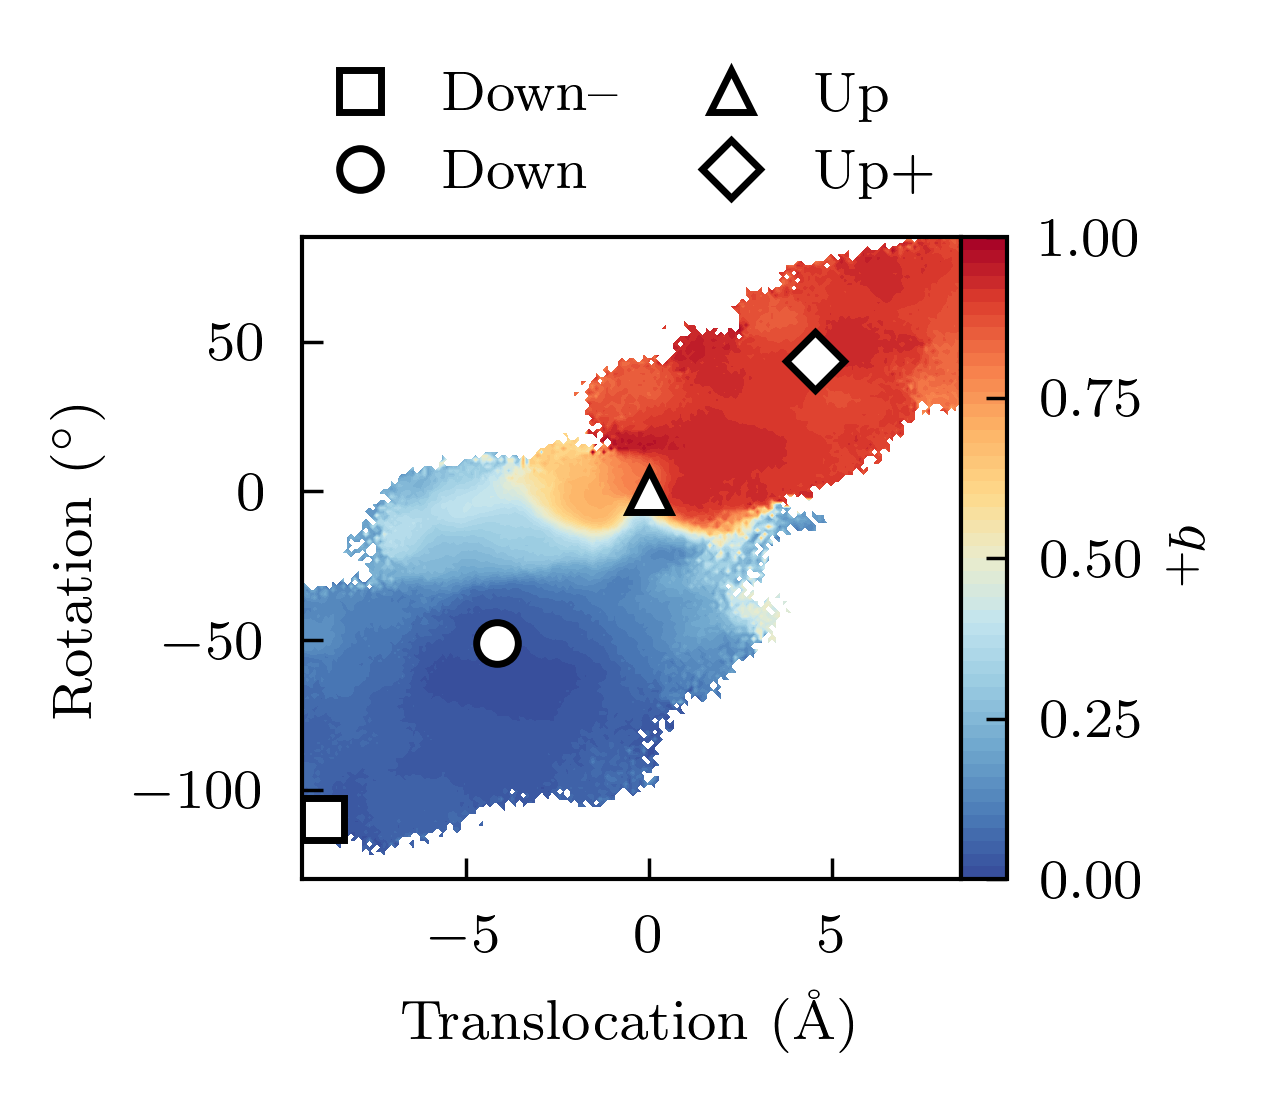

In [15]:
f, ax = plt.subplots(figsize=(1.7, 1.7), dpi=500, sharex=True, sharey=True)
# bin commitors
xe = np.linspace(-10, 10, 201)
ye = np.linspace(-150, 100, 201)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
q_dens = extq.projection.average2d(
    dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye
)
# plot committors
# pc1 = ax.pcolor(xe, ye, q_dens.T, cmap='diverging', vmin=0, vmax=1)
plotting.format_cvs(ax, centroids=False, ms=6, zorder=5)
f.legend(
    bbox_to_anchor=(0.5, 1.0),
    loc="center",
    ncol=2,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=1,
    handletextpad=0.5,
)

levels = np.linspace(0, 1.0, 51)
pc1 = ax.contourf(
    xcent, ycent, q_dens.T, cmap="diverging", levels=levels, vmin=0, vmax=1
)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax_ins.set_ylim([ymin, ymax])


cb1 = pplt.colorbar(pc1, ax=ax)
cb1.set_label("$q_+$", rotation=-90, labelpad=10)
cb1.set_ticks(np.linspace(0, 1, 5))
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Hysteresis in side chains

In [15]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

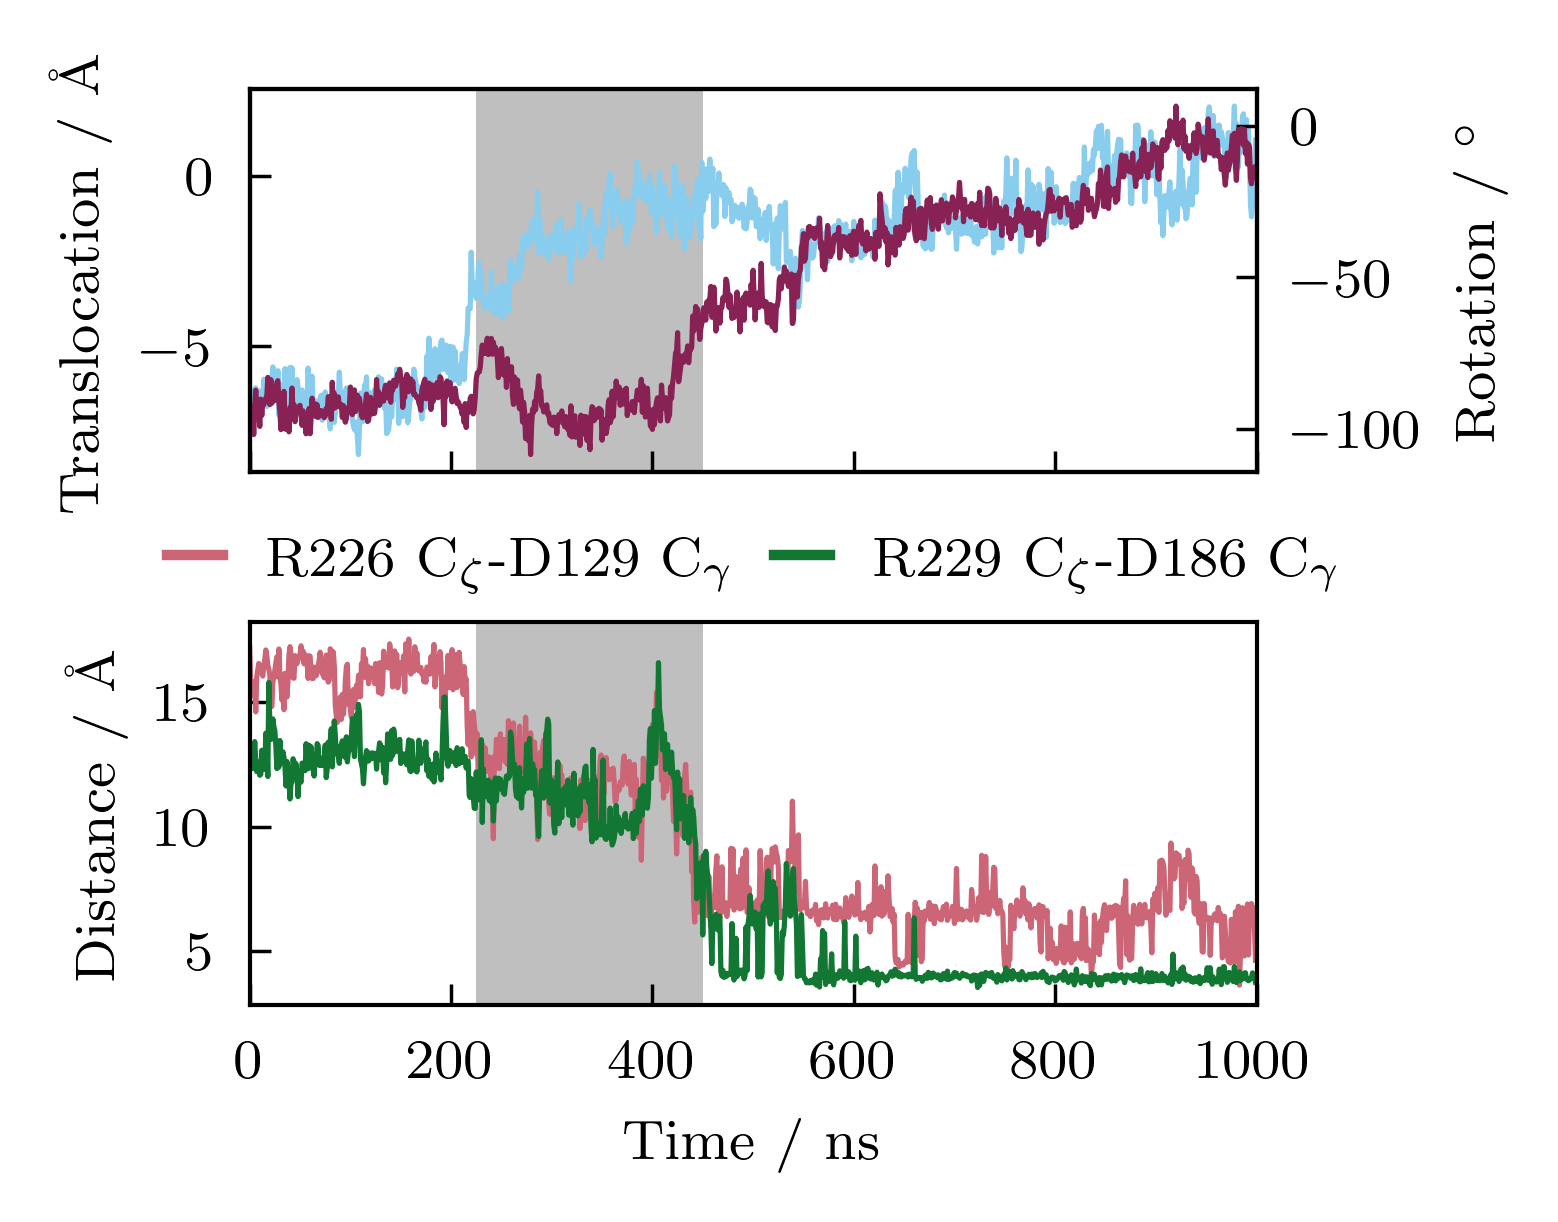

In [40]:
f, (ax0, ax1) = plt.subplots(
    2, 1, sharex=True, figsize=(3.0, 2.25), constrained_layout=True, dpi=500
)

end = 10000
skip = 10
traj_id = 171
t = np.arange(0, end / skip) * 0.1 * skip  # units of ns

# plot salt bridge distance
ax0.plot(t, cv_trajs[traj_id][:end:skip, 0], "C4", label="Translocation")
ax0.set_ylabel("Translocation / Å")

ax0_r = ax0.twinx()
ax0_r.plot(t, cv_trajs[traj_id][:end:skip, 1], "C5", label="Rotation")
ax0_r.set_ylabel("Rotation / $^\circ$")
ax0.set_xlim([0, 10])

# R2-D129
ax1.plot(t, sb_trajs[traj_id][:end:skip, 42] * 10, "C0", label=f"{sb_names[42]}")
# R3-D186
ax1.plot(t, sb_trajs[traj_id][:end:skip, 53] * 10, "C3", label=f"{sb_names[53]}")
leg = ax1.legend(
    ncol=2, bbox_to_anchor=(0.5, 1.15), loc="center", handlelength=1, columnspacing=0.75
)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
ax1.set(xlabel="Time / ns", ylabel="Distance / Å", xlim=[0, 1000])
ax1.set_xlim([0, 1000])

for ax in (ax0, ax1):
    ax.axvspan(225, 450, alpha=0.5, color="grey", ec=None)

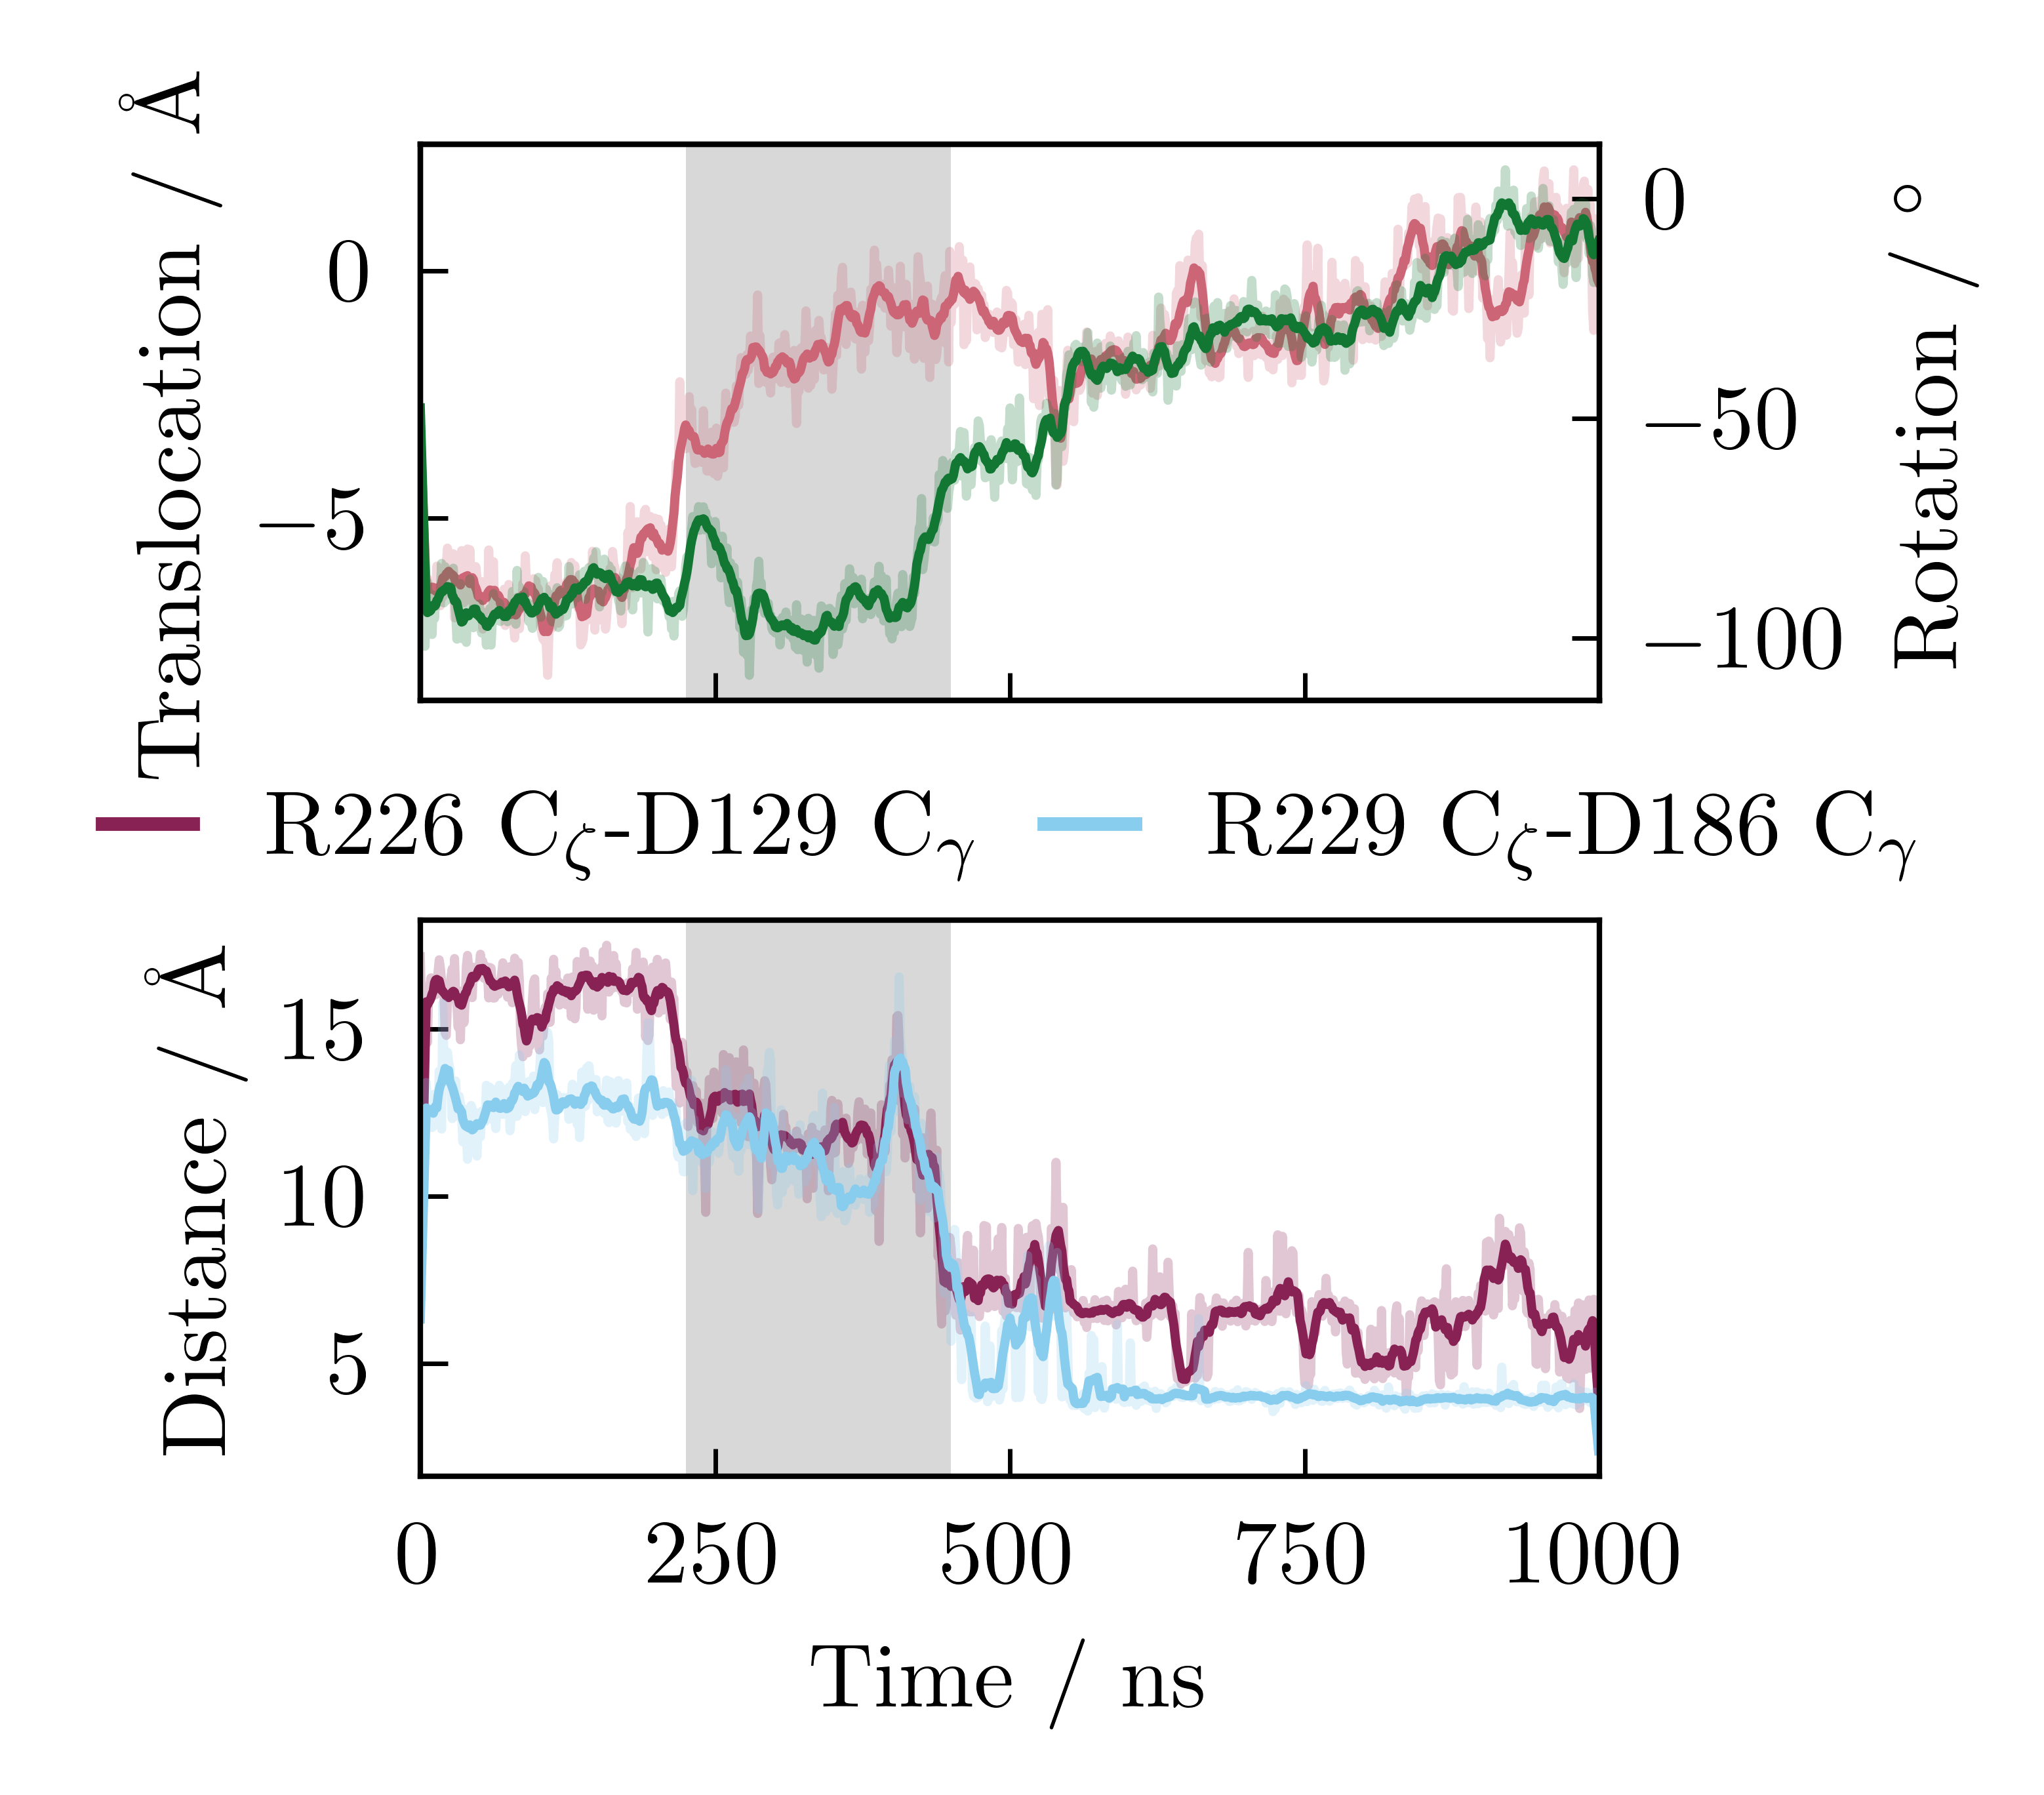

In [19]:
f, (ax0, ax1) = plt.subplots(
    2, 1, sharex=True, figsize=(3.0, 2.5), constrained_layout=True, dpi=500
)

end = 10000
skip = 10
traj_id = 171
lw = 1.0
t = np.arange(0, end / skip) * 0.1 * skip  # units of ns

# plot salt bridge distance
ax0.plot(t, util.moving_average(cv_trajs[traj_id][:end:skip, 0], 10), "C0", lw=lw, label="Translocation")
ax0.plot(t, cv_trajs[traj_id][:end:skip, 0], "C0", lw=lw, alpha=0.25)
ax0.set_ylabel("Translocation / Å")

ax0_r = ax0.twinx()
ax0_r.plot(t, util.moving_average(cv_trajs[traj_id][:end:skip, 1], 10), "C3", lw=lw, label="Rotation")
ax0_r.plot(t, cv_trajs[traj_id][:end:skip, 1], "C3", lw=lw, alpha=0.25, label="Rotation")
ax0_r.set_ylabel("Rotation / $^\circ$")
ax0.set_xlim([0, 10])

# R2-D129
ax1.plot(t, util.moving_average(sb_trajs[traj_id][:end:skip, 42] * 10, 10), "C5", lw=lw, label=f"{sb_names[42]}")
ax1.plot(t, sb_trajs[traj_id][:end:skip, 42] * 10, "C5", lw=lw, alpha=0.25)
# R3-D186
ax1.plot(t, util.moving_average(sb_trajs[traj_id][:end:skip, 53] * 10, 10), "C4", lw=lw, label=f"{sb_names[53]}")
ax1.plot(t, sb_trajs[traj_id][:end:skip, 53] * 10, "C4", lw=lw, alpha=0.25)

leg = ax1.legend(
    ncol=2, bbox_to_anchor=(0.5, 1.15), loc="center", handlelength=1, columnspacing=0.75
)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
ax1.set(xlabel="Time / ns", ylabel="Distance / Å", xlim=[0, 1000])
ax1.set_xlim([0, 1000])

for ax in (ax0, ax1):
    ax.axvspan(225, 450, alpha=0.3, color="grey", ec=None)
    
plt.savefig("../../fig/paper/fig1_sb_hysteresis.pdf", bbox_inches='tight')

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


NameError: name 'xmin' is not defined

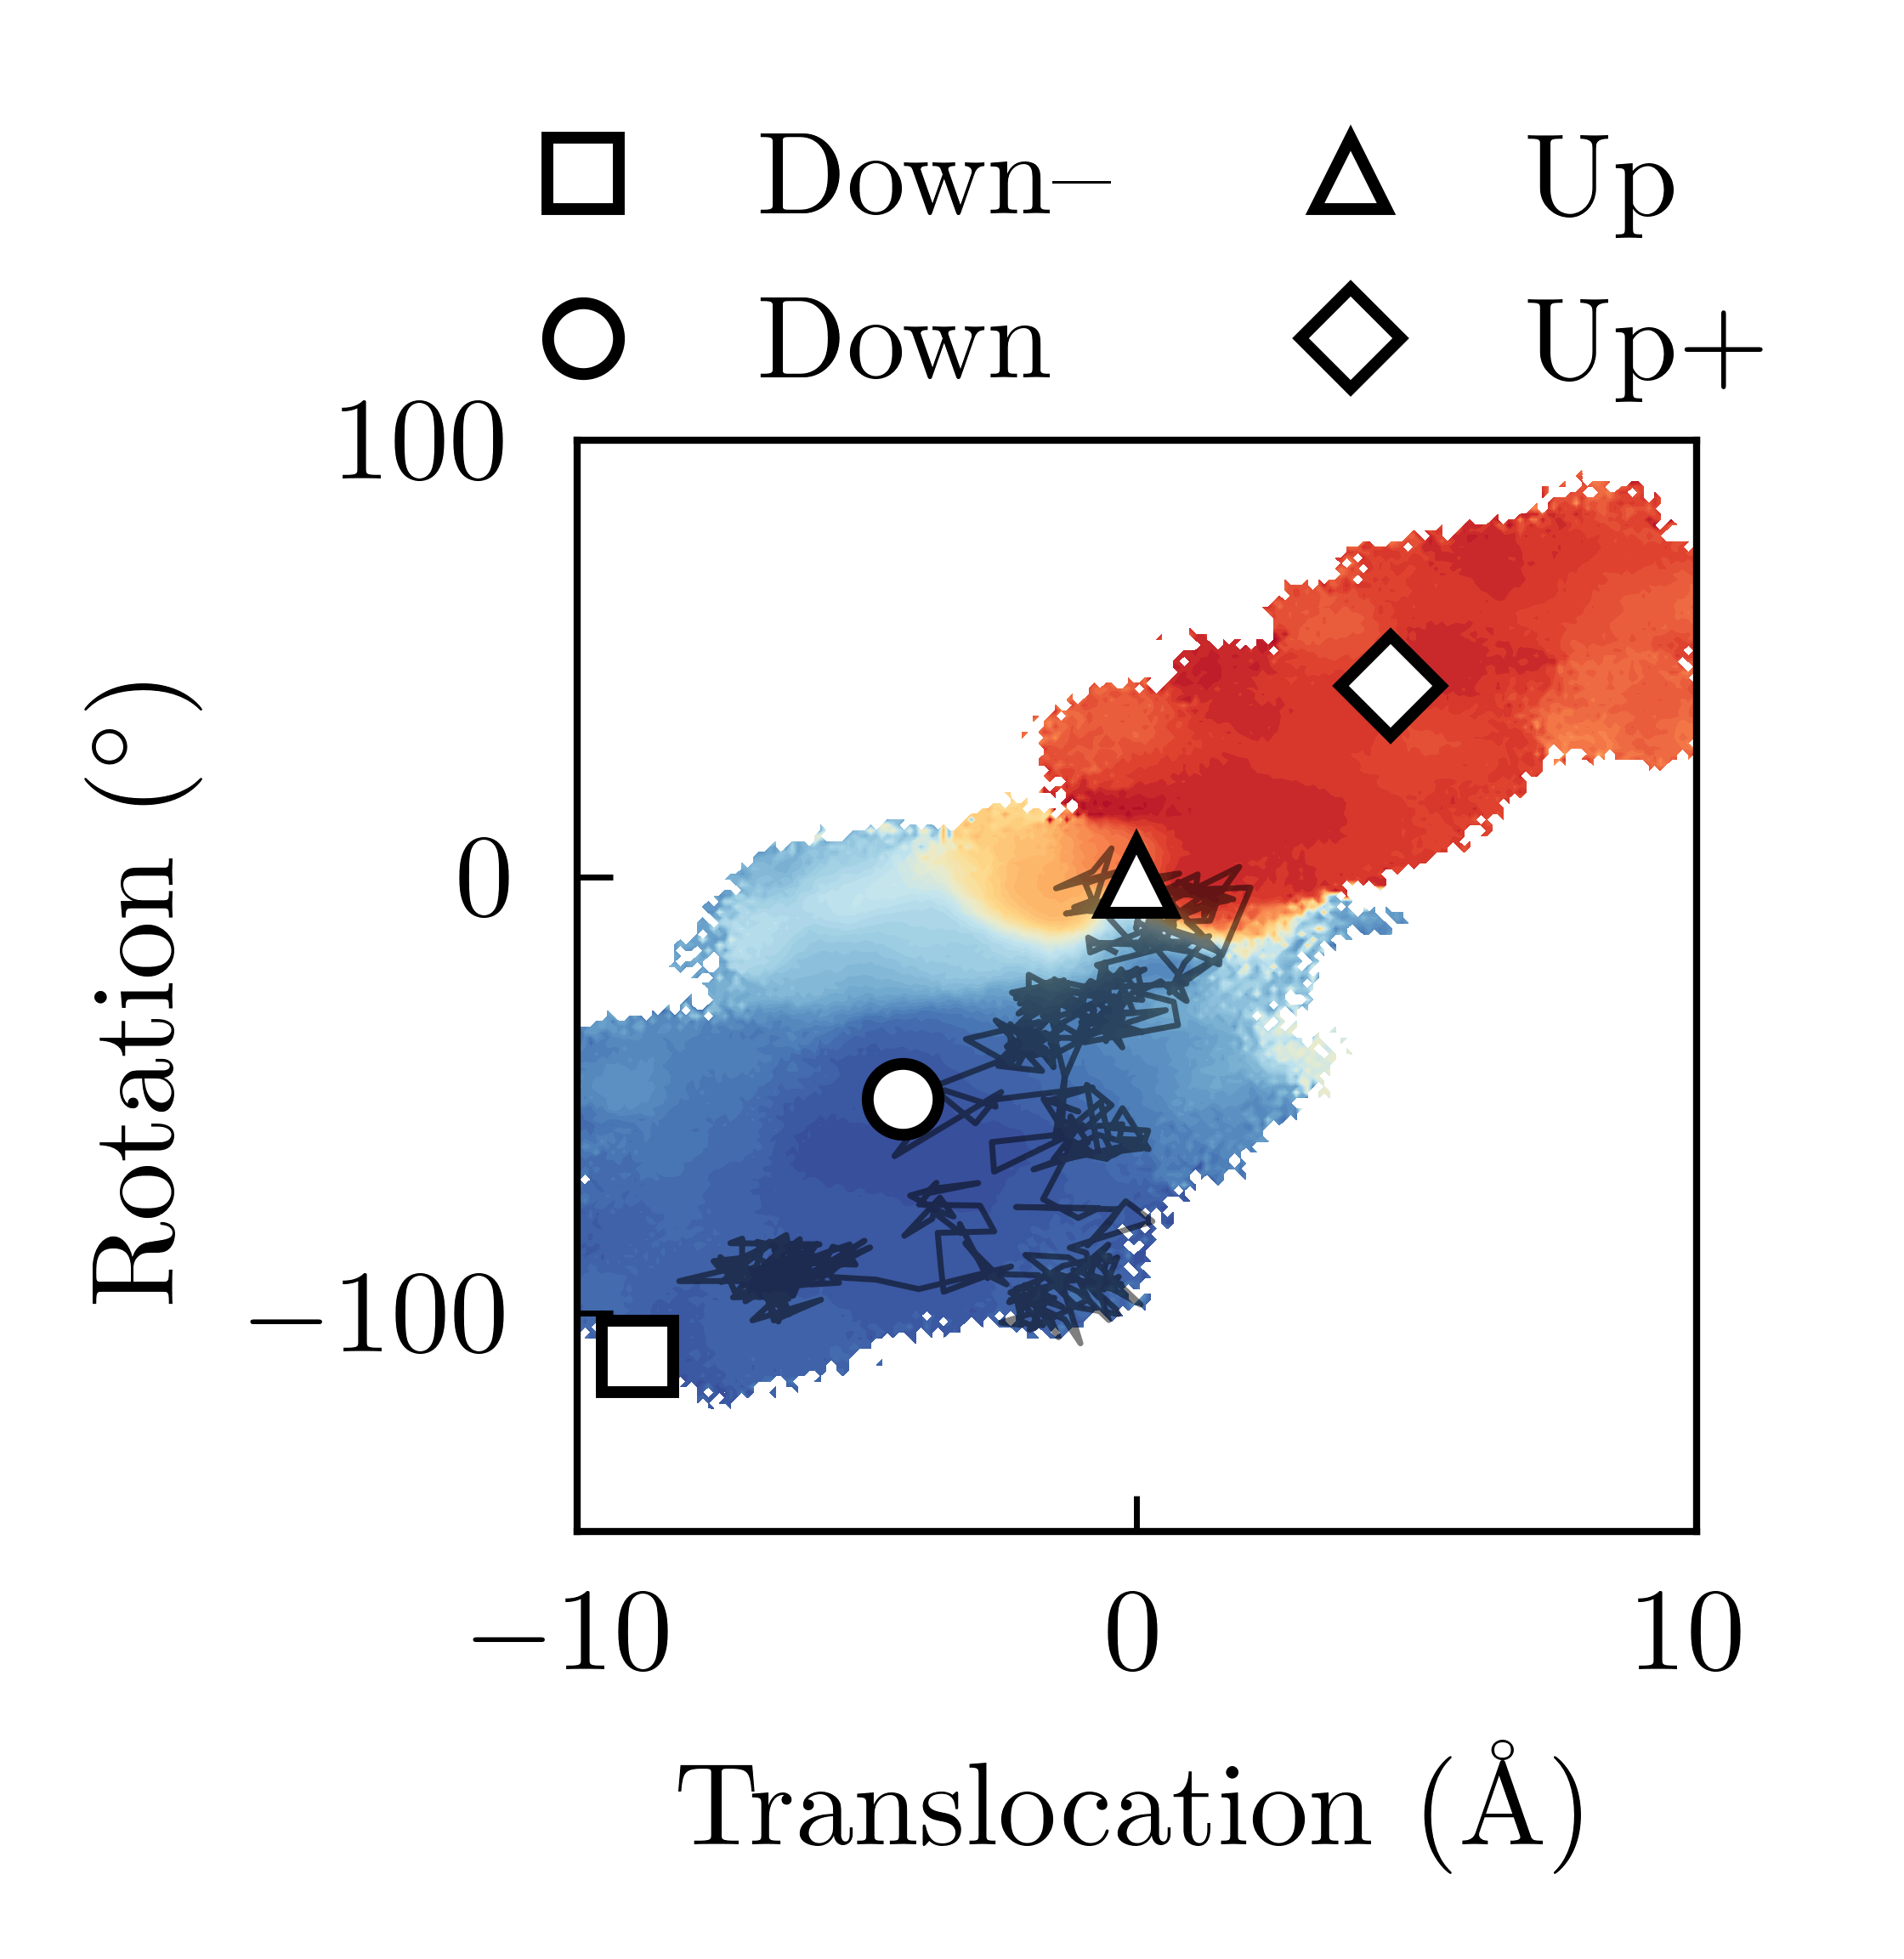

In [33]:
f, ax = plt.subplots(figsize=(1.7, 1.7), dpi=500, sharex=True, sharey=True)
# bin commitors
xe = np.linspace(-10, 10, 201)
ye = np.linspace(-150, 100, 201)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
q_dens = extq.projection.average2d(
    dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye
)
# plot committors
# pc1 = ax.pcolor(xe, ye, q_dens.T, cmap='diverging', vmin=0, vmax=1)
plotting.format_cvs(ax, centroids=False, ms=6, zorder=5)
f.legend(
    bbox_to_anchor=(0.5, 1.0),
    loc="center",
    ncol=2,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=1,
    handletextpad=0.5,
)

levels = np.linspace(0, 1.0, 51)
pc1 = ax.contourf(
    xcent, ycent, q_dens.T, cmap="diverging", levels=levels, vmin=0, vmax=1
)
ax.plot(
    cv_trajs[traj_id][:end:20, 0],
    cv_trajs[traj_id][:end:20, 1],
    "black",
    lw=0.5,
    alpha=0.5,
)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax_ins.set_ylim([ymin, ymax])


cb1 = pplt.colorbar(pc1, ax=ax)
cb1.set_label("$q_+$", rotation=-90, labelpad=10)
cb1.set_ticks(np.linspace(0, 1, 5))
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Comparison with REUS

/scratch/local/jobs/5590455/ipykernel_2443008/2794743031.py:30: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7fb6a6e977f0> has a label of '_' which cannot be automatically added to the legend.
  f.legend(


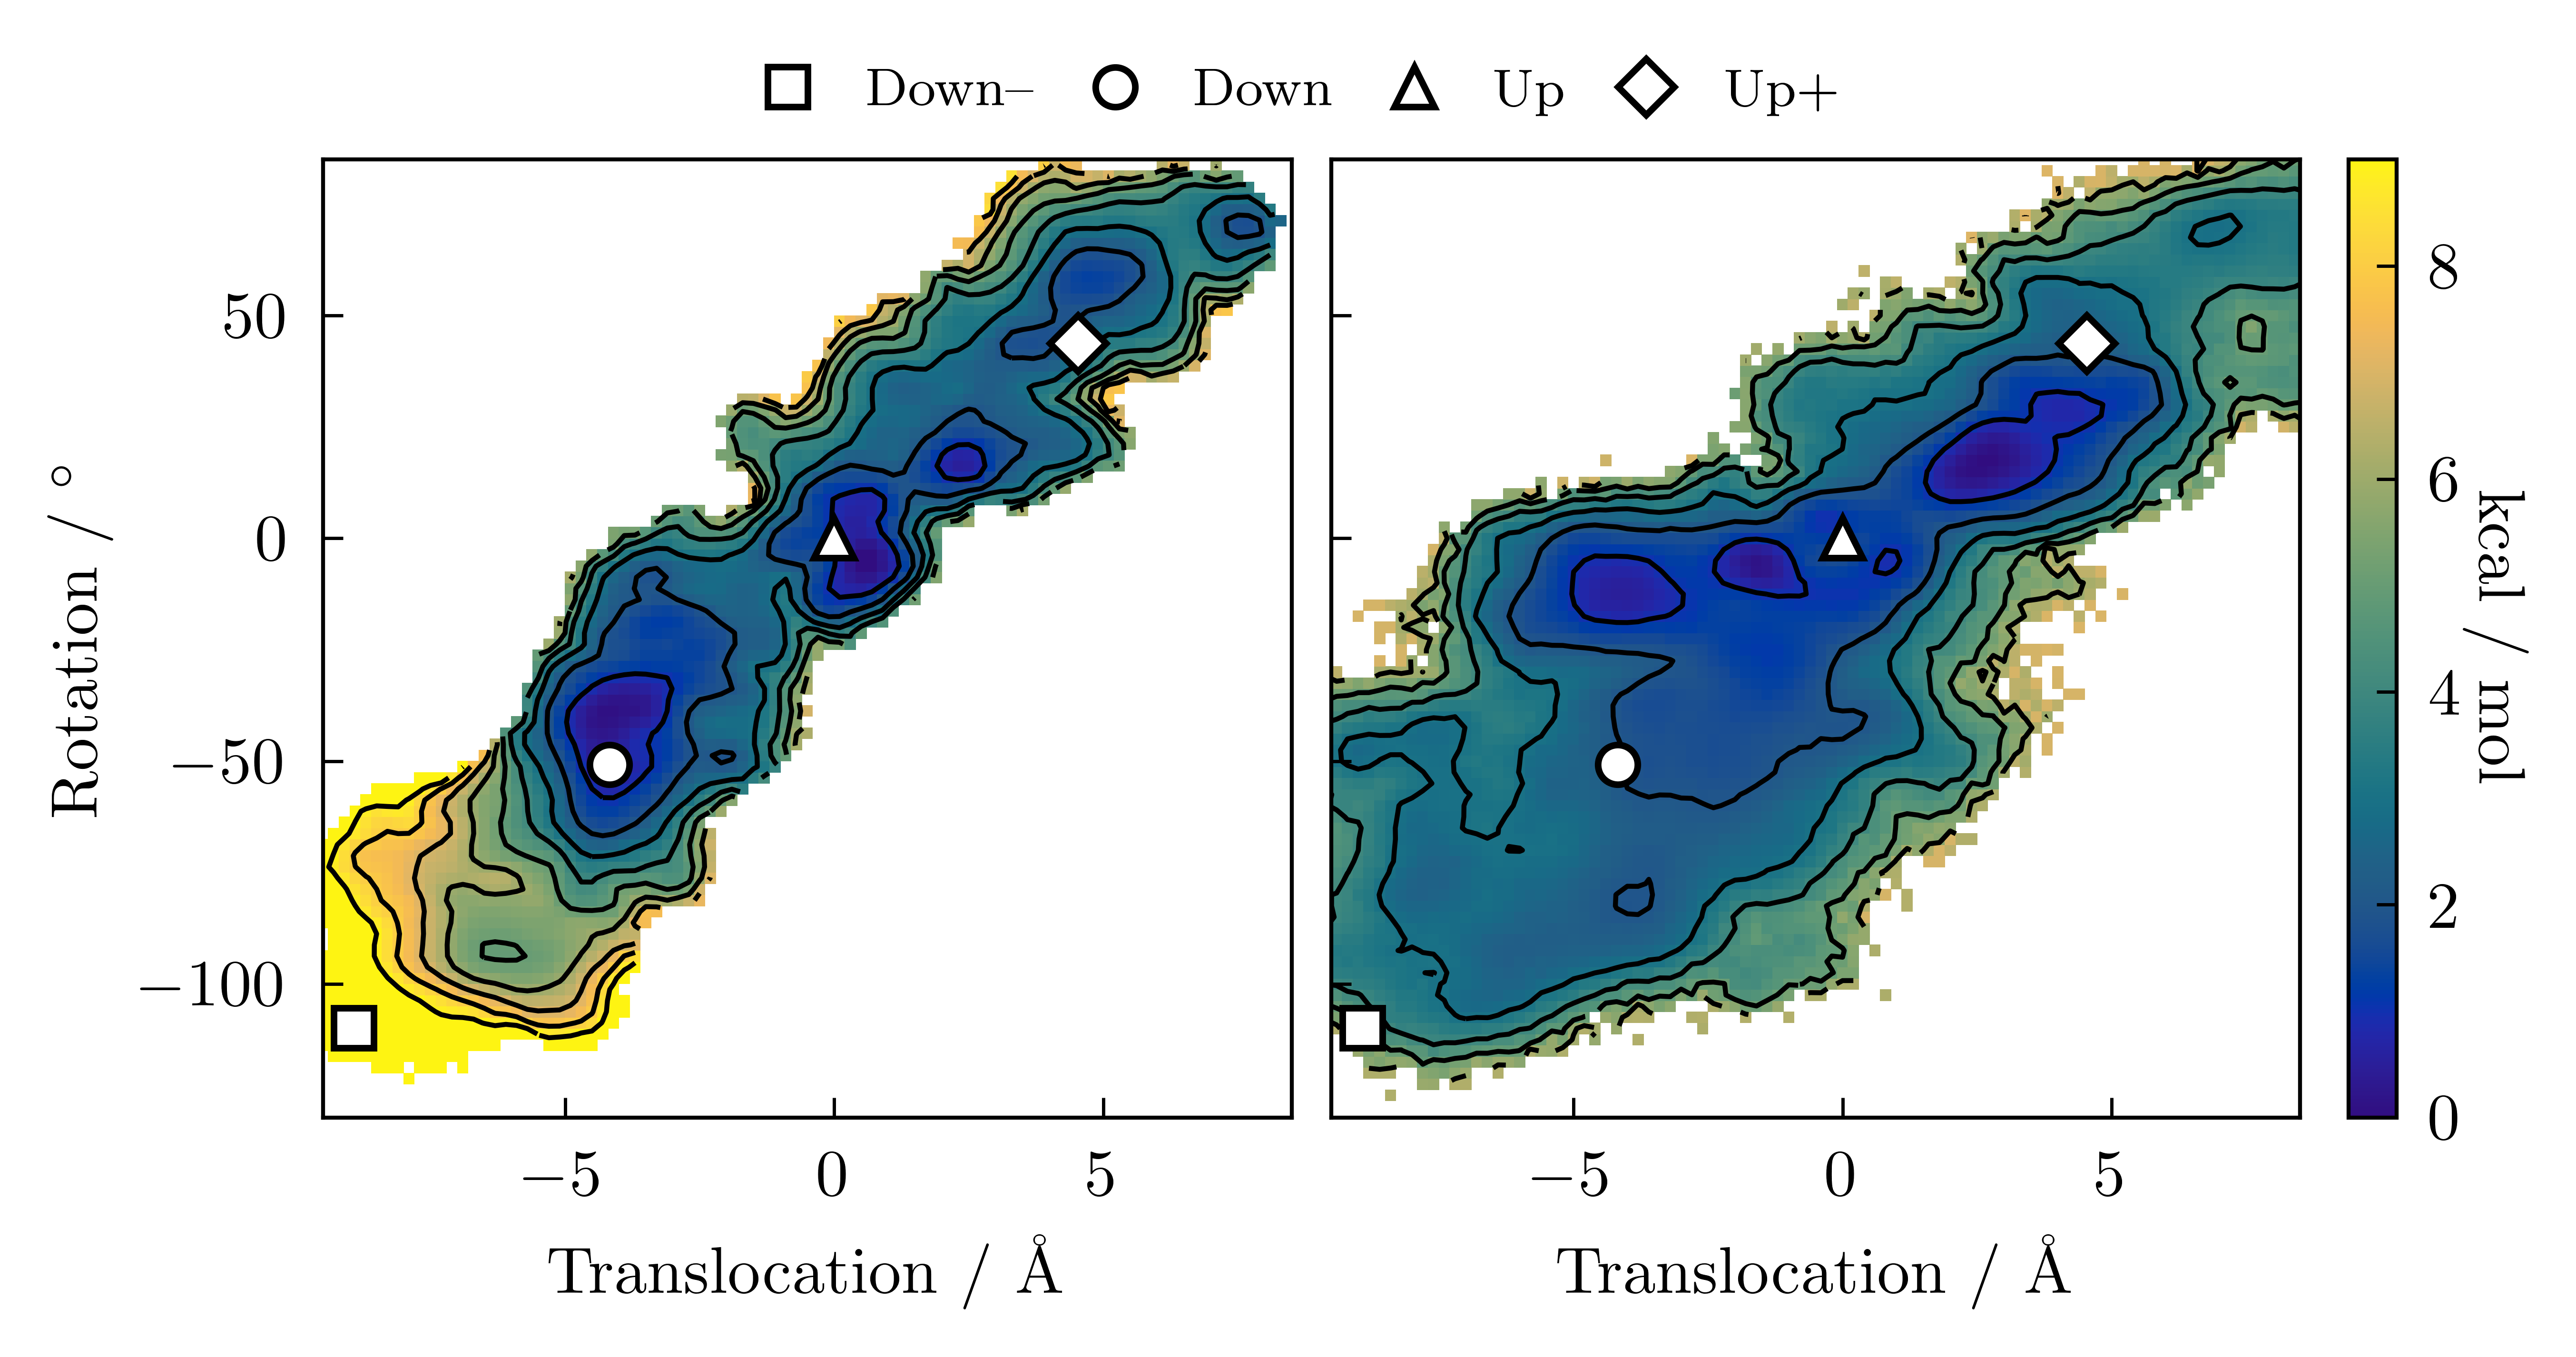

In [14]:
f, (ax0, ax1) = plt.subplots(
    1, 2, figsize=(5.3, 2.5), dpi=500, sharex=True, sharey=True, constrained_layout=True
)

vmin, vmax = 0, 9
clines = np.linspace(vmin, vmax, (vmax - vmin) + 1)  # contour lines spaced every 1 kcal/mol

xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85

# plot PMF
xcent = (xlim[1:] + xlim[:-1]) / 2
ycent = (ylim[1:] + ylim[:-1]) / 2
pc0 = ax0.pcolor(
    xlim,
    ylim,
    pmf_ref[:, :, 2].T,
    cmap="macaw",
    shading="auto",
    vmin=vmin,
    vmax=vmax,
    rasterized=True,
)
ax0.contour(xlim, ylim, pmf_ref[:, :, 2].T, levels=clines, colors="black")

pc1 = ax1.pcolor(xlim, ylim, diff.T, cmap="macaw", shading="auto", vmin=vmin, vmax=vmax, rasterized=True)
ax1.contour(xcent, ycent, diff.T, levels=clines, colors="black")

plotting.format_cvs(ax0, centroids=False, ms=6, zorder=5)
plotting.format_cvs(ax1, centroids=False, ms=6, zorder=5)
f.legend(
    bbox_to_anchor=(0.5, 1.04),
    loc="center",
    ncol=4,
    labels=["_", "Down–", "Down", "Up", "Up+"],
    columnspacing=0.5,
    handletextpad=0.5,
    fontsize=8,
)
for ax in (ax0, ax1):
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel("Translocation / Å")
    ax.set_ylabel("Rotation / $^\circ$")
    ax.label_outer()

cb = plt.colorbar(pc1, ax=ax1)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
plt.savefig("../../fig/paper/ds_pmf_compare.pdf", bbox_inches="tight")

# Violin plots of S4 helix CVs

In [13]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [14]:
steps, q_inds = bin_inds(qp_du, qstep=0.1, low=0.15, hi=0.85)

In [15]:
steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.1f}")
    else:
        steplabels.append("")

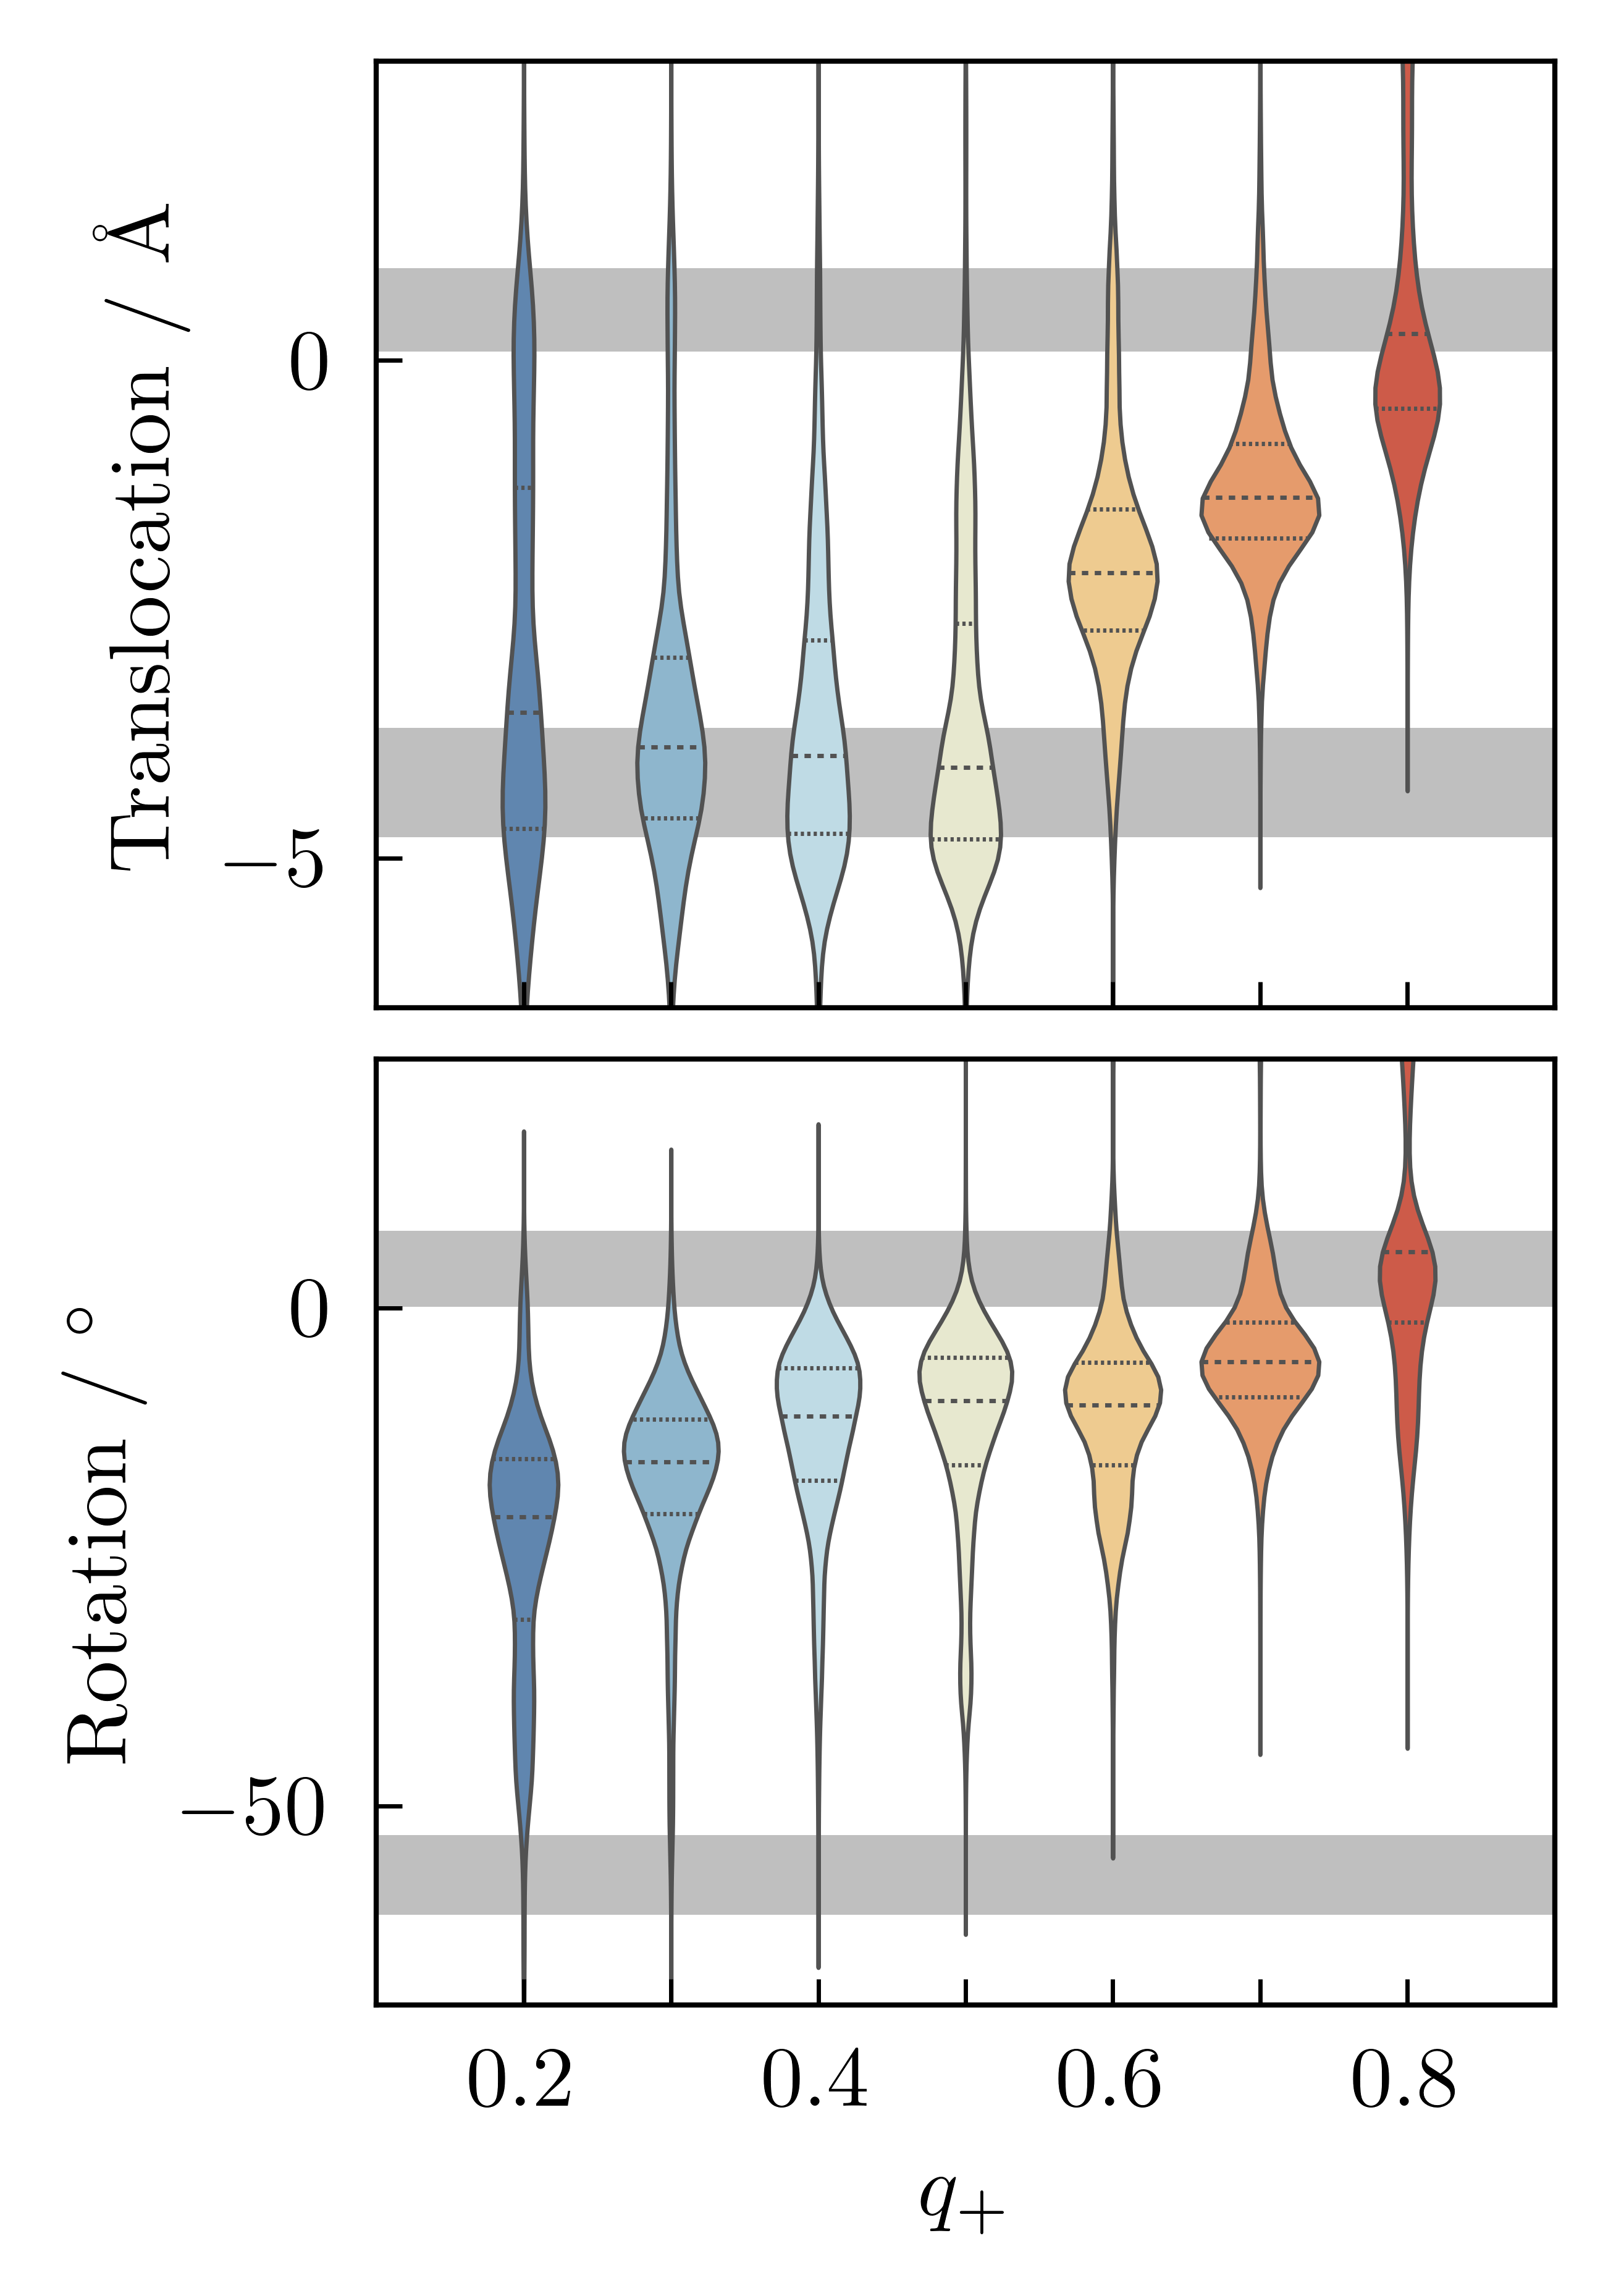

In [30]:
f, (ax0, ax1) = plt.subplots(2, 1, figsize=(2.5, 3.6), dpi=500, constrained_layout=True, sharex=True)
sns.violinplot(
    ax=ax0,
    data=[cv_arr[inds, 0] for inds in q_inds],
    scale="area",
    bw=0.1,
    inner="quartile",
    palette="diverging",
    orient="v",
    linewidth=0.5,
)

ax0.set_xticklabels(steplabels)
ax0.set_xlabel("$q_+$")
ax0.set_ylabel("Translocation / Å")
ax0.set_ylim([-6.5, 3])
ax0.set_yticks([-5, 0])
ax0.axhspan(-4.240 - 0.55, -4.24 + 0.55, color="grey", alpha=0.5, zorder=0, ec=None)
ax0.axhspan(0.506 - 0.42, 0.506 + 0.42, color="grey", alpha=0.5, zorder=0, ec=None)
ax0.set_xlim([-1, 7])
ax0.label_outer()

sns.violinplot(
    ax=ax1,
    data=[cv_arr[inds, 1] for inds in q_inds],
    scale="area",
    bw=0.1,
    inner="quartile",
    palette="diverging",
    orient="v",
    linewidth=0.5,
)
ax1.set_xticklabels(steplabels)
ax1.set_xlabel("$q_+$")
ax1.set_ylabel("Rotation / $^\circ$")
ax1.set_yticks([-50, 0])
ax1.set_ylim([-70, 25])
ax1.axhspan(-56.95 - 4, -56.95 + 4, color="grey", alpha=0.5, zorder=0, ec=None)
ax1.axhspan(3.94 - 3.8, 3.94 + 3.8, color="grey", alpha=0.5, zorder=0, ec=None)
ax1.set_xlim([-1, 7])
# ax1.invert_yaxis()
plt.savefig("../../fig/paper/ds_violins.pdf", bbox_inches="tight")

# Currents

In [20]:
# color arrows from transparent to white depending on magnitude
rgb = 255 / 256
colors = [(rgb, rgb, rgb, c) for c in np.linspace(0.1, 1, 100)]
cmapwhite = mpl.colors.LinearSegmentedColormap.from_list("white", colors)

In [21]:
rgb_black = 1 / 256
colors_black = [(rgb_black, rgb_black, rgb_black, c) for c in np.linspace(0.05, 1, 100)]
cmapblack = mpl.colors.LinearSegmentedColormap.from_list("black", colors_black)
mpl.colormaps.register(cmapblack, force=True)

In [22]:
def plot_pmf_current(
    cv1,
    cv2,
    j,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    n_pmf,
    clines,
    cm_pmf="macaw",
    cm_j=cmapwhite,
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    xlim = np.linspace(xmin, xmax, n_pmf)
    ylim = np.linspace(ymin, ymax, n_pmf)
    centerx = (xlim[1:] + xlim[:-1]) / 2
    centery = (ylim[1:] + ylim[:-1]) / 2

    pmf = extq.projection.density2d(cv1, cv2, weights, xlim, ylim)

    if ax is None:
        ax = plt.gca()
    ax, pc = plotting.plot_pmf(ax, pmf, xlim, ylim, units="kcal", clines=clines, cmap=cm_pmf)
    # KDE bin fluxes
    jx_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 0]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 1]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned**2 + jy_binned**2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.007,
        cmap=cm_j,
        headwidth=2.5,
        headlength=2.5,
        headaxislength=2.5,
        scale=20,
        scale_units="width",
        zorder=5,
    )

    return ax, pc, quiv

In [23]:
def plot_current(
    cv1,
    cv2,
    j,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    cm_j=cmapwhite,
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    if ax is None:
        ax = plt.gca()
    # KDE bin fluxes
    jx_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 0]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 1]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned**2 + jy_binned**2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.008,
        cmap=cm_j,
        headwidth=4,
        headlength=4,
        headaxislength=3,
        scale=15,
        scale_units="width",
        zorder=5,
    )

    return ax, quiv

In [24]:
centroids = np.loadtxt("/project/dinner/scguo/ci-vsd/models/MD-clustering-center/all.txt")

/scratch/local/jobs/5869204/ipykernel_3457291/286977087.py:7: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1f143a5bb0> has a label of '_' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)
/scratch/local/jobs/5869204/ipykernel_3457291/286977087.py:7: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1f143b8400> has a label of '_' which cannot be automatically added to the legend.
  f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)
/scratch/local/jobs/5869204/ipykernel_3457291/286977087.py:20: RuntimeWarning: divide by zero encountered in log
  diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol
/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


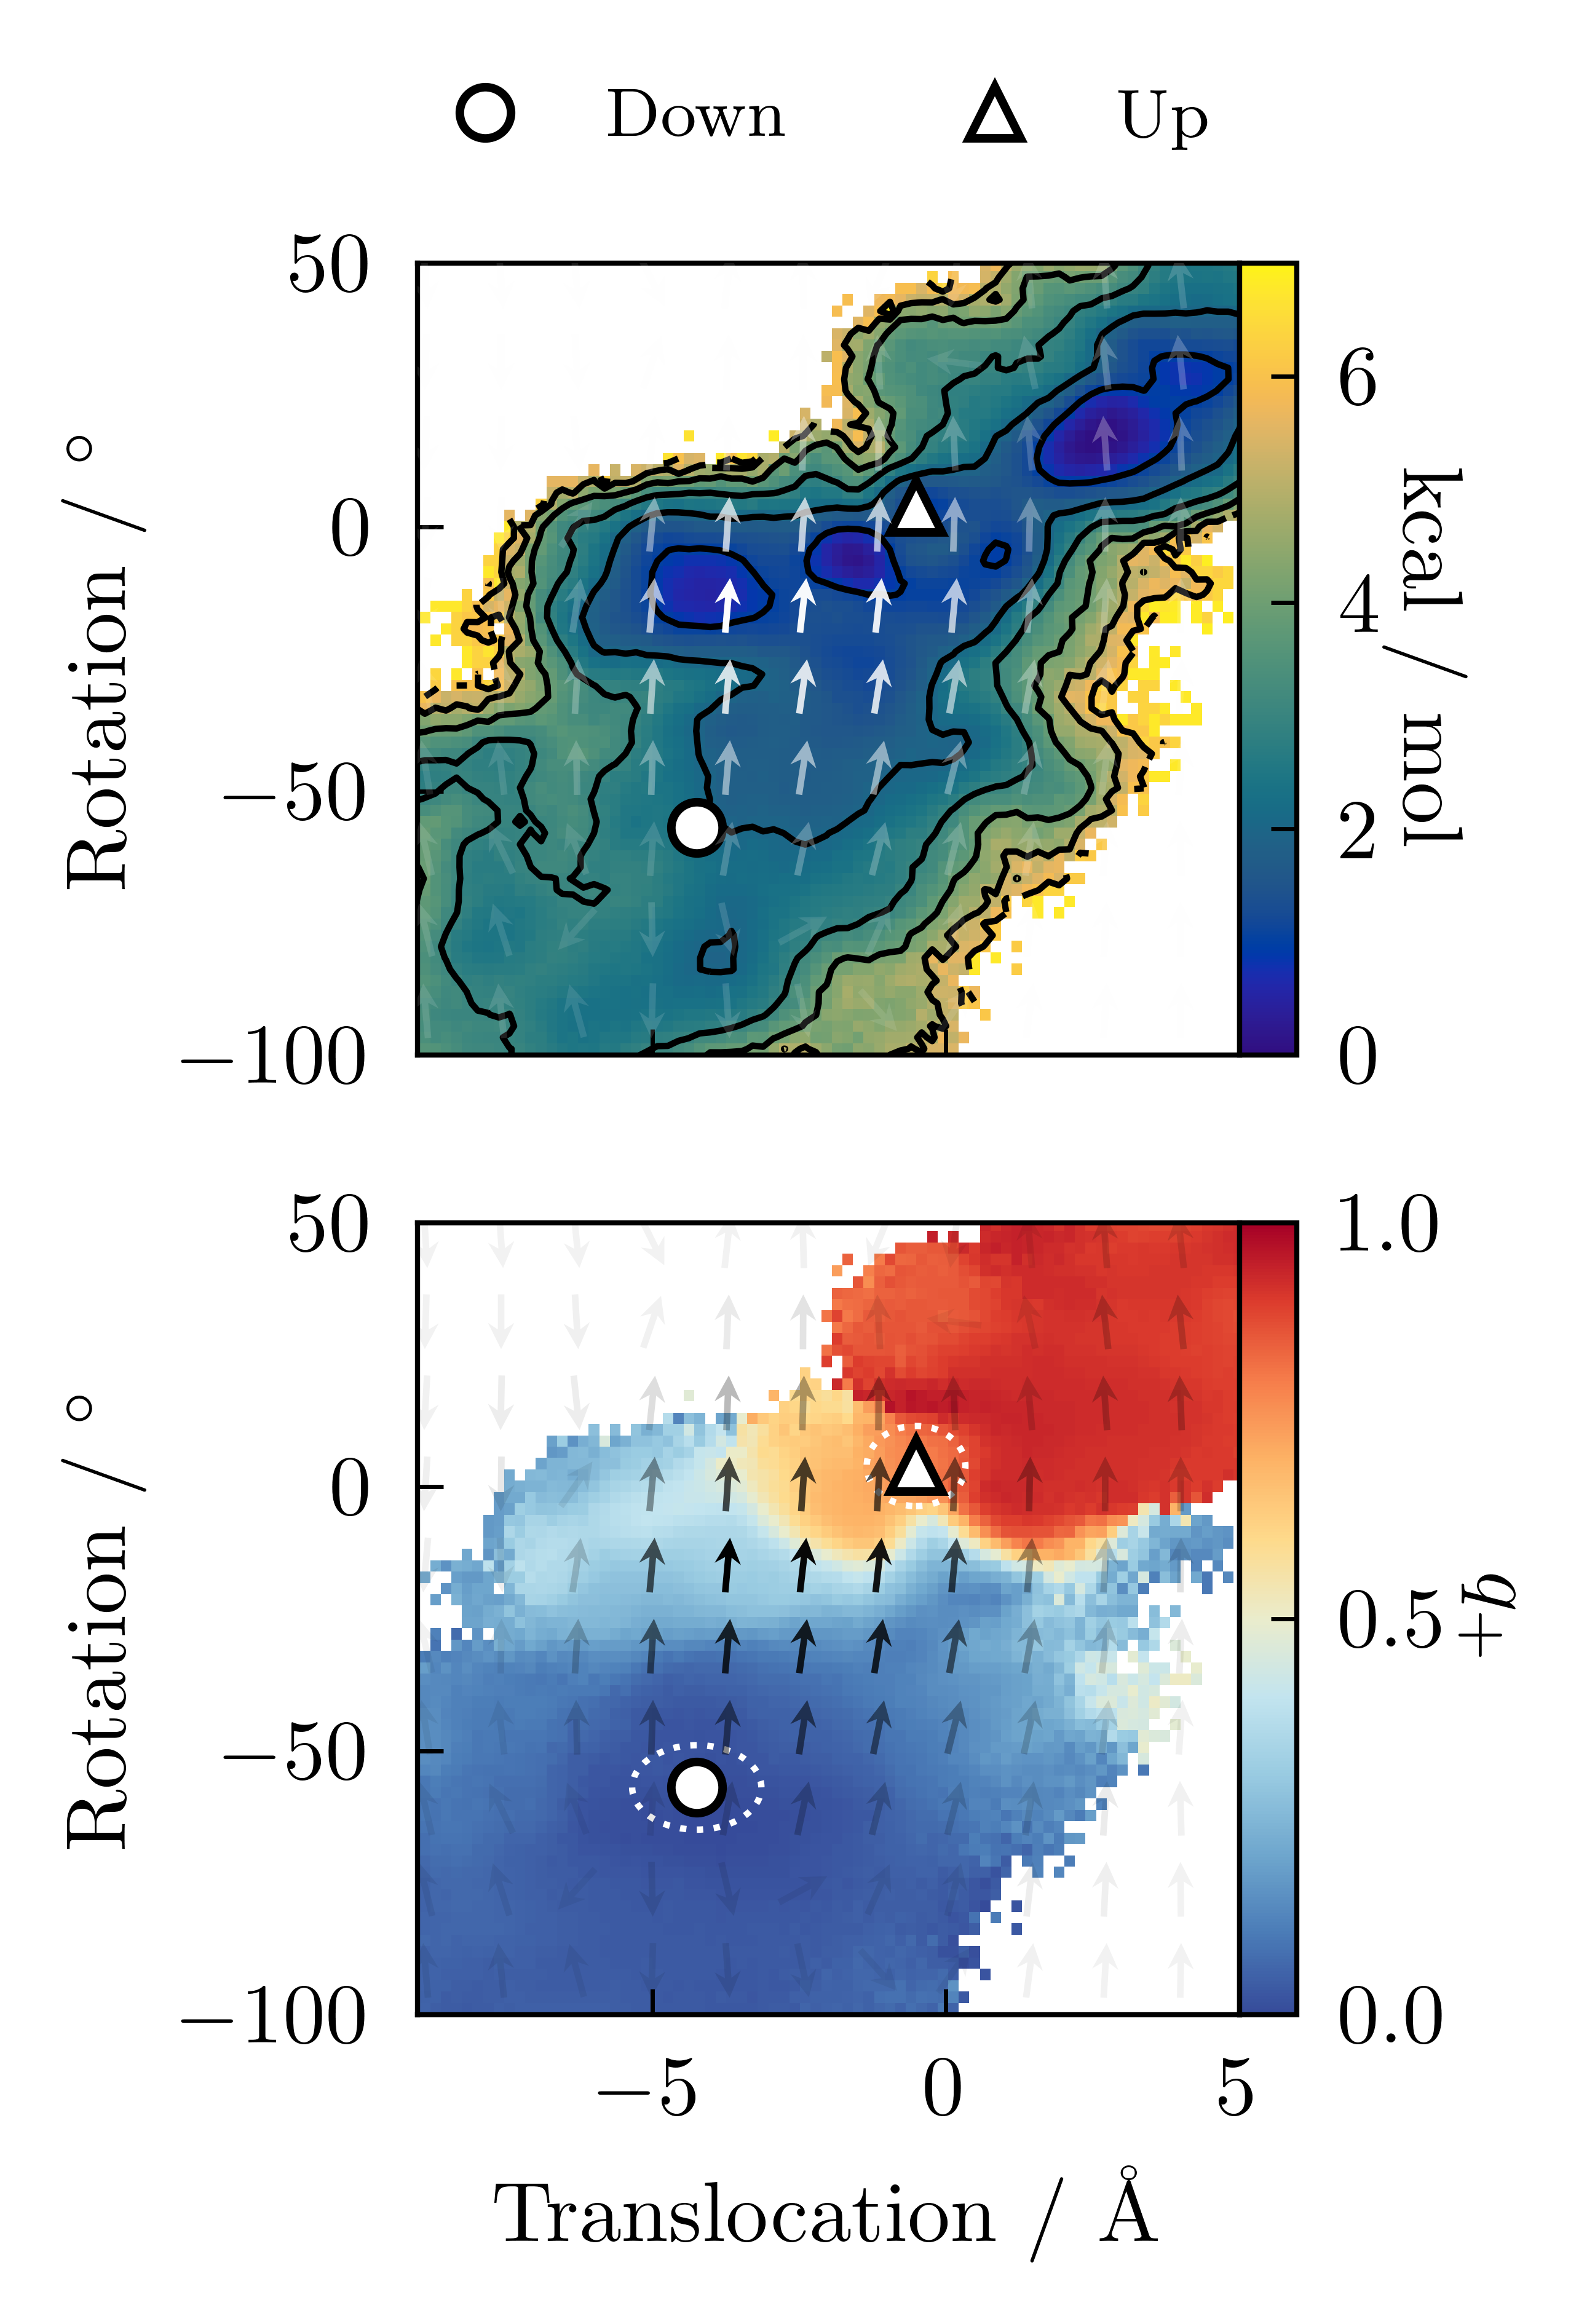

In [29]:
vmin, vmax = 0, 7
clines = np.linspace(vmin, vmax, (vmax - vmin) + 1)  # contour lines spaced every 1 kcal/mol

f, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(2.75, 3.6), dpi=500)
plotting.plot_models(ax0, centroids, ms=6, zorder=5)
plotting.plot_models(ax1, centroids, ms=6, zorder=5)
f.legend(bbox_to_anchor=(0.5, 1.01), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)

# PMF + current
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2

pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights, xe, ye)
offset = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol

pc0 = ax0.pcolormesh(xcent, ycent, diff.T, cmap="macaw", vmin=vmin, vmax=vmax, rasterized=True)
ax0.contour(xcent, ycent, diff.T, colors="black")
cb = pplt.colorbar(pc0, ax=ax0)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
# cb.set_ticks(np.linspace(0, 6, 4))
# current
plot_current(dist_trajs, rot_trajs, j_du_ds, weights, xmin, xmax, ymin, ymax, 14, cm_j=cmapwhite, ax=ax0)

# committor + current
q_dens = extq.projection.average2d(dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye)
# plot committors
levels = np.linspace(0, 1.0, 51)
pc1 = ax1.pcolormesh(xcent, ycent, q_dens.T, cmap="diverging", vmin=0, vmax=1, rasterized=True)
cb1 = pplt.colorbar(pc1, ax=ax1)
cb1.set_label("$q_+$", rotation=-90, labelpad=10)
cb1.set_ticks(np.linspace(0, 1, 3))
plot_current(dist_trajs, rot_trajs, j_du_ds, weights, xmin, xmax, ymin, ymax, 14, cm_j=cmapblack, ax=ax1)

ellipseA = mpl.patches.Ellipse(xy=(-4.24, -56.95), width=2.2, height=16)
ellipseB = mpl.patches.Ellipse(xy=(-0.506, 3.94), width=0.84 * 2, height=7.6 * 2)
for e in (ellipseA, ellipseB):
    e.set_fill(False)
    e.set_linestyle(":")
    e.set_linewidth(0.75)
    e.set_edgecolor("white")
ax1.add_artist(ellipseA)
ax1.add_artist(ellipseB)

for ax in (ax0, ax1):
    ax.set(xlim=[-9, 5], ylim=[-100, 50])
    ax.set_xlabel("Translocation / Å")
    ax.set_ylabel("Rotation / $^\circ$")
    ax.label_outer()
plt.tight_layout()
plt.savefig("../../fig/paper/ds_pmf_q_j.pdf", bbox_inches='tight')

/scratch/local/jobs/5869204/ipykernel_3457291/3457620850.py:7: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1eb4237d60> has a label of '_' which cannot be automatically added to the legend.
  ax0.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)
/scratch/local/jobs/5869204/ipykernel_3457291/3457620850.py:7: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1eb4247640> has a label of '_' which cannot be automatically added to the legend.
  ax0.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)
/scratch/local/jobs/5869204/ipykernel_3457291/3457620850.py:20: RuntimeWarning: divide by zero encountered in log
  diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol


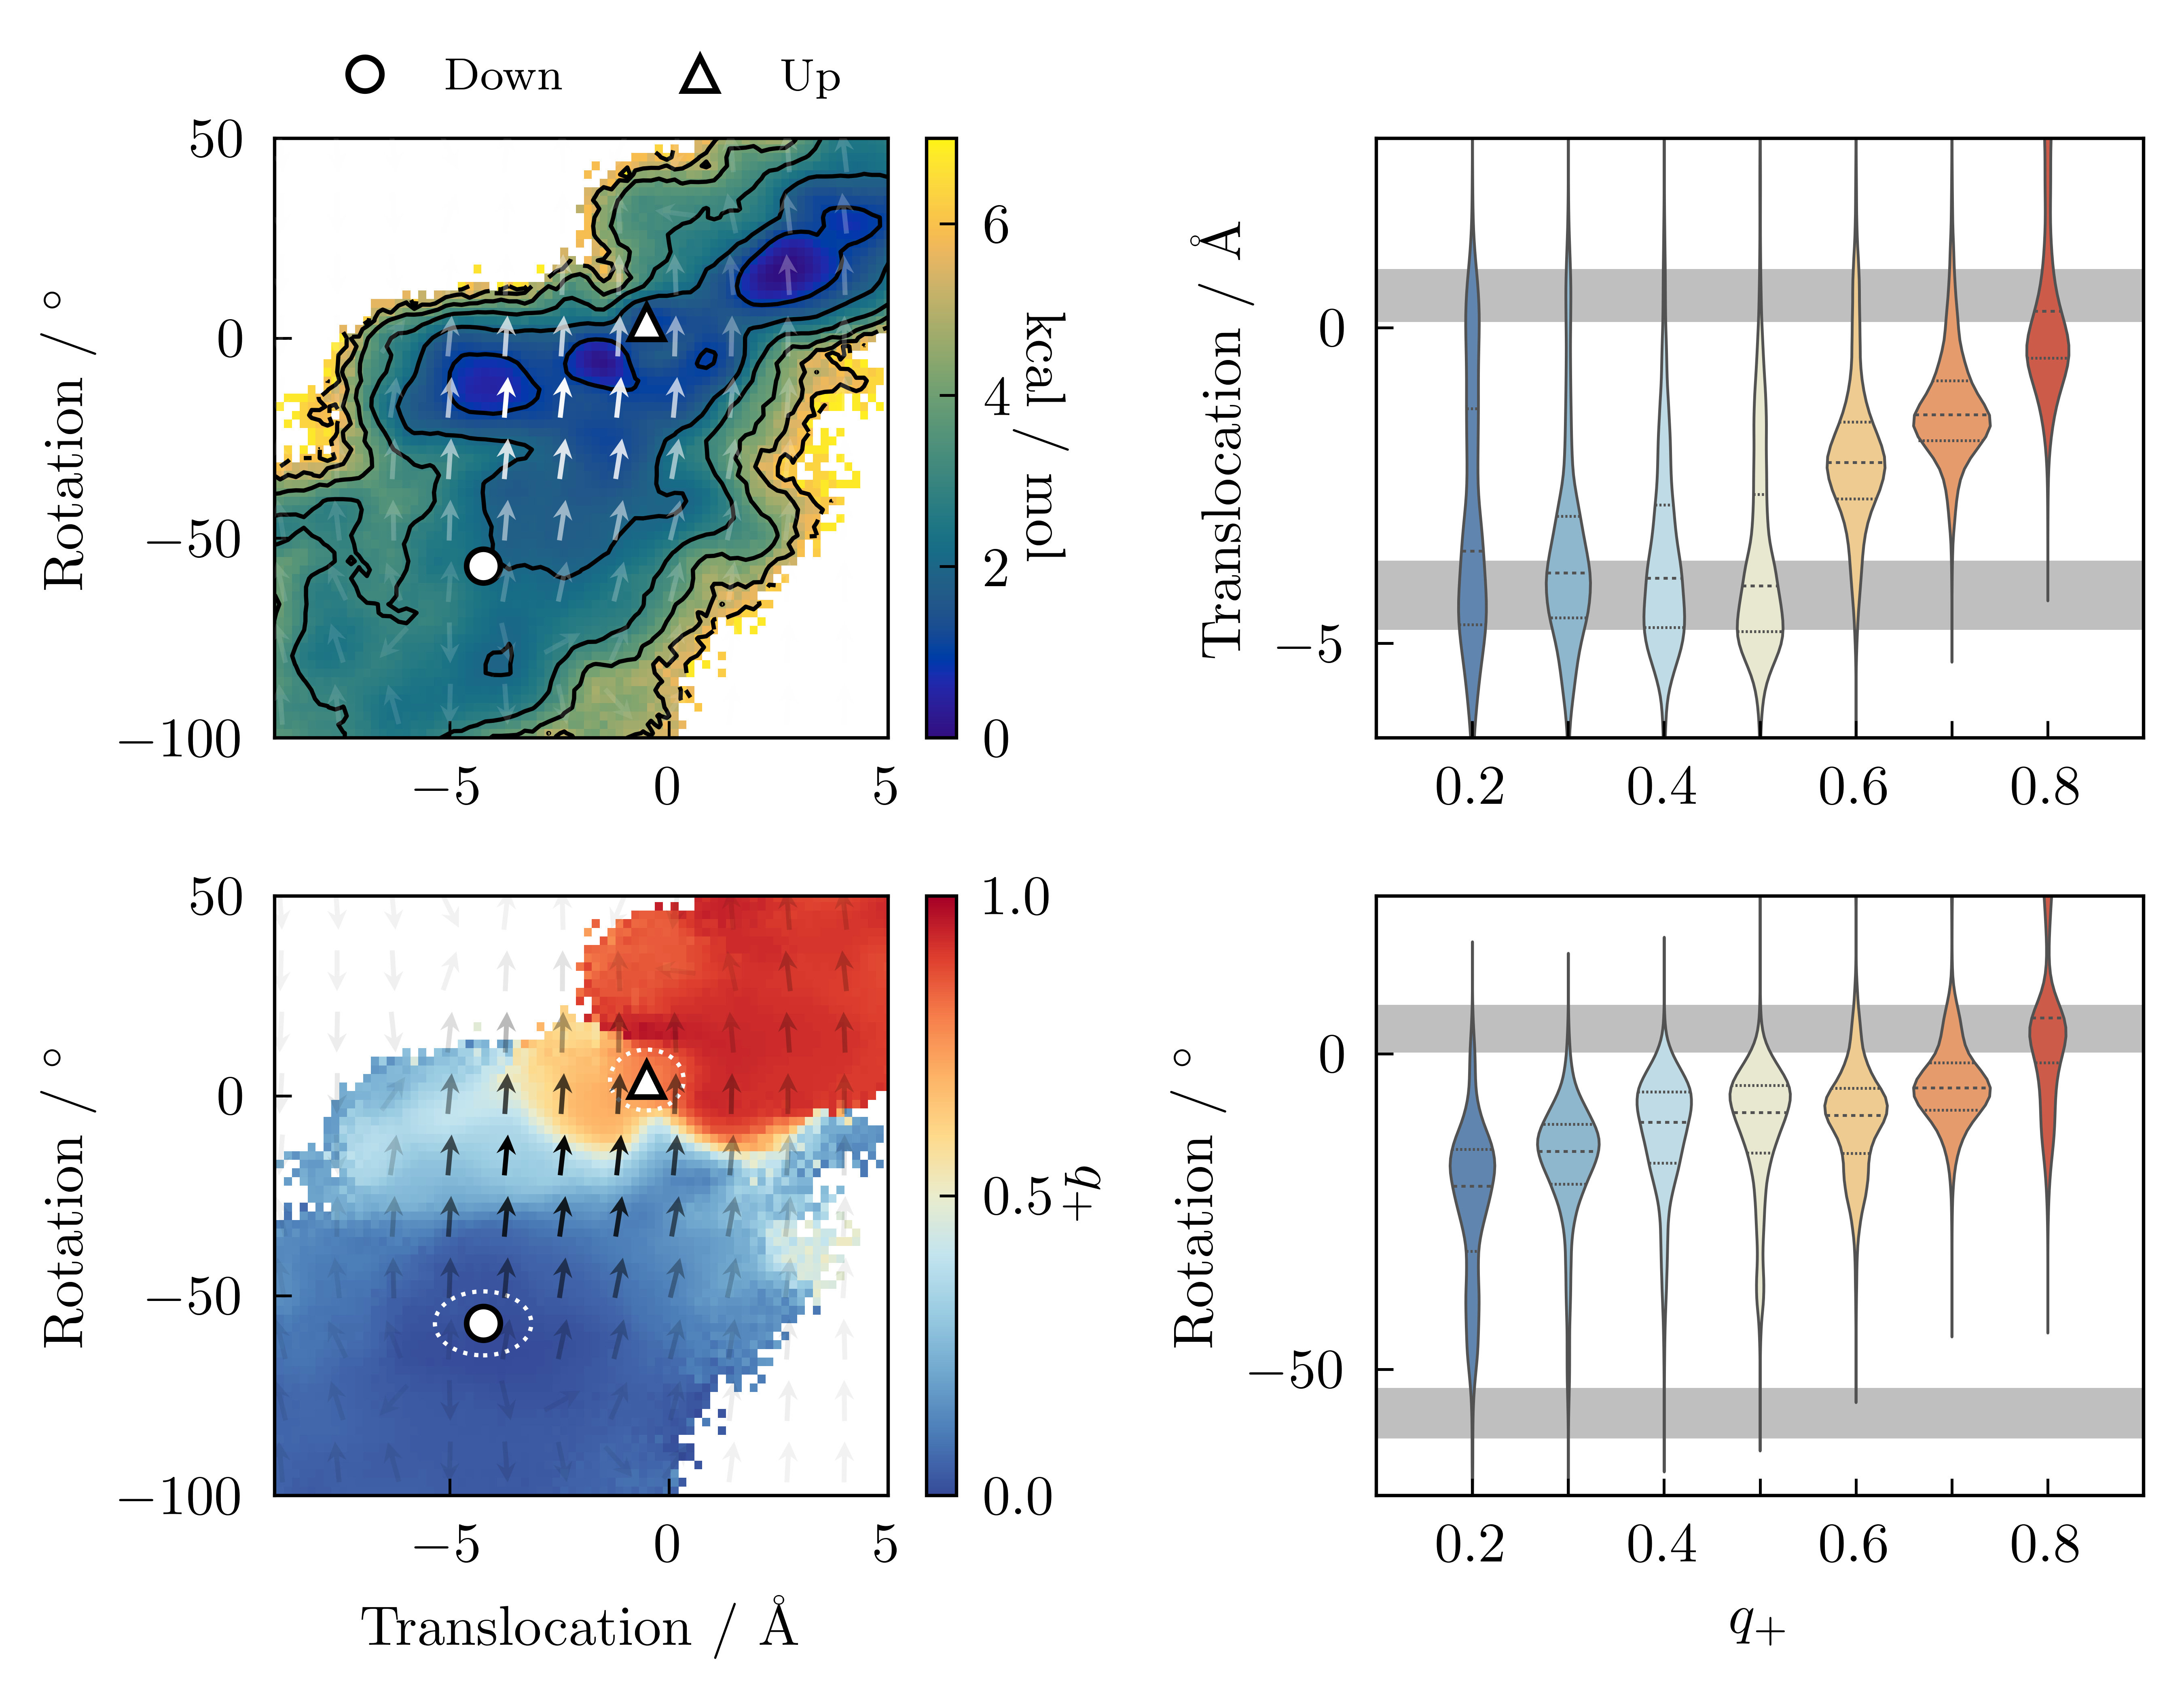

In [36]:
vmin, vmax = 0, 7
clines = np.linspace(vmin, vmax, (vmax - vmin) + 1)  # contour lines spaced every 1 kcal/mol

f, ((ax0, ax2), (ax1, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 4.3), dpi=500)
plotting.plot_models(ax0, centroids, ms=6, zorder=5)
plotting.plot_models(ax1, centroids, ms=6, zorder=5)
ax0.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncol=4, labels=["_", "Down", "Up", "_"], fontsize=8)

# PMF + current
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2

pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights, xe, ye)
offset = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol

pc0 = ax0.pcolormesh(xcent, ycent, diff.T, cmap="macaw", vmin=vmin, vmax=vmax, rasterized=True)
ax0.contour(xcent, ycent, diff.T, colors="black")
cb = plt.colorbar(pc0, ax=ax0)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
# cb.set_ticks(np.linspace(0, 6, 4))
# current
plot_current(dist_trajs, rot_trajs, j_du_ds, weights, xmin, xmax, ymin, ymax, 14, cm_j=cmapwhite, ax=ax0)

# committor + current
q_dens = extq.projection.average2d(dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye)
# plot committors
levels = np.linspace(0, 1.0, 51)
pc1 = ax1.pcolormesh(xcent, ycent, q_dens.T, cmap="diverging", vmin=0, vmax=1, rasterized=True)
cb1 = plt.colorbar(pc1, ax=ax1)
cb1.set_label("$q_+$", rotation=-90, labelpad=10)
cb1.set_ticks(np.linspace(0, 1, 3))
plot_current(dist_trajs, rot_trajs, j_du_ds, weights, xmin, xmax, ymin, ymax, 14, cm_j=cmapblack, ax=ax1)

ellipseA = mpl.patches.Ellipse(xy=(-4.24, -56.95), width=2.2, height=16)
ellipseB = mpl.patches.Ellipse(xy=(-0.506, 3.94), width=0.84 * 2, height=7.6 * 2)
for e in (ellipseA, ellipseB):
    e.set_fill(False)
    e.set_linestyle(":")
    e.set_linewidth(0.75)
    e.set_edgecolor("white")
ax1.add_artist(ellipseA)
ax1.add_artist(ellipseB)

for ax in (ax0, ax1):
    ax.set(xlim=[-9, 5], ylim=[-100, 50])
    ax.set_ylabel("Rotation / $^\circ$")
    ax.label_outer()
ax1.set_xlabel("Translocation / Å")

sns.violinplot(
    ax=ax2,
    data=[cv_arr[inds, 0] for inds in q_inds],
    scale="area",
    bw=0.1,
    inner="quartile",
    palette="diverging",
    orient="v",
    linewidth=0.5,
)

ax2.set_xticklabels(steplabels)
# ax2.set_xlabel("$q_+$")
ax2.set_ylabel("Translocation / Å")
ax2.set_ylim([-6.5, 3])
ax2.set_yticks([-5, 0])
ax2.axhspan(-4.240 - 0.55, -4.24 + 0.55, color="grey", alpha=0.5, zorder=0, ec=None)
ax2.axhspan(0.506 - 0.42, 0.506 + 0.42, color="grey", alpha=0.5, zorder=0, ec=None)
ax2.set_xlim([-1, 7])

sns.violinplot(
    ax=ax3,
    data=[cv_arr[inds, 1] for inds in q_inds],
    scale="area",
    bw=0.1,
    inner="quartile",
    palette="diverging",
    orient="v",
    linewidth=0.5,
)
ax3.set_xticklabels(steplabels)
ax3.set_xlabel("$q_+$")
ax3.set_ylabel("Rotation / $^\circ$")
ax3.set_yticks([-50, 0])
ax3.set_ylim([-70, 25])
ax3.axhspan(-56.95 - 4, -56.95 + 4, color="grey", alpha=0.5, zorder=0, ec=None)
ax3.axhspan(3.94 - 3.8, 3.94 + 3.8, color="grey", alpha=0.5, zorder=0, ec=None)
ax3.set_xlim([-1, 7])
plt.tight_layout()
plt.savefig("../../fig/paper/ds_all.pdf", bbox_inches='tight')